# Compare ablation area

Author: Ziqi Yin

Last modified: 2025 Jan 27

Table of contents:
* [Annual mean ablation area and ELA variations and their relationship](#first-bullet)
* [Relationships between albedo/ELA/ablation area and JJA mean temperature](#second-bullet)

In [1]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from statistics import mode
import pandas as pd
from scipy import signal
from scipy import interpolate
from scipy import stats
import scipy.sparse as sps # For reading weight files
from math import radians, sin, cos, sqrt, atan2

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as colors
from matplotlib.collections import PolyCollection
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import cartopy
import cartopy.crs as ccrs
crs_np = ccrs.NorthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()
from cartopy.util import add_cyclic_point
from holoviews.operation.datashader import datashade, rasterize, regrid

home_dir = '/glade/work/ziqiyin/'
import sys  
sys.path.insert(0, home_dir)
sys.path.append(home_dir + 'function/')
from functions import *

import warnings
warnings.filterwarnings('ignore')

# For regridding
import os
import ESMF
import xesmf as xe

# Polynomial regression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [2]:
## Parameter
g = 9.80616 #[m/s2]

## 1. Annual mean ablation area and ELA variations and their relationship <a class="anchor" id="first-bullet"></a>

### Get data

#### CAM/CLM

In [12]:
## f09muntjewerf
# 1pctCO2
f09_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RAIN_1pctCO2_yearly.nc')['RAIN'][:140]
f09_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_SNOW_1pctCO2_yearly.nc')['SNOW'][:140]
f09_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:140]
f09_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:140]
f09_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT'][:140]
f09_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:140]
f09_1pctCO2_PHIS_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_1pctCO2_JJA_yearly.nc')['PHIS'][:140]
f09_lon = f09_1pctCO2_RAIN_yearly.lon
f09_lat = f09_1pctCO2_RAIN_yearly.lat

# 4xCO2
f09_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_RAIN_4xext_yearly.nc')['RAIN']
f09_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_SNOW_4xext_yearly.nc')['SNOW']
f09_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
f09_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
f09_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT']
f09_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_QRUNOFF_4xext_yearly.nc')['QRUNOFF']
f09_4xext_PHIS_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PHIS_4xext_JJA_yearly.nc')['PHIS']

# Combine
f09_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_1pctCO2_RAIN_yearly, f09_4xext_RAIN_yearly], dim='time')
f09_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_1pctCO2_SNOW_yearly, f09_4xext_SNOW_yearly], dim='time')
f09_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_1pctCO2_QICE_MELT_yearly, f09_4xext_QICE_MELT_yearly], dim='time')
f09_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_1pctCO2_QSNOMELT_yearly, f09_4xext_QSNOMELT_yearly], dim='time')
f09_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([f09_1pctCO2_QFLX_EVAP_TOT_yearly, f09_4xext_QFLX_EVAP_TOT_yearly], dim='time')
f09_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_1pctCO2_QRUNOFF_yearly, f09_4xext_QRUNOFF_yearly], dim='time')
f09_1pctCO2_4xext_PHIS_yearly = xr.concat([f09_1pctCO2_PHIS_yearly, f09_4xext_PHIS_yearly], dim='time')

In [13]:
## f09nohacks
# 1pctCO2
f09_nohacks_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RAIN_1pctCO2_yearly.nc')['RAIN'][:]
f09_nohacks_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_SNOW_1pctCO2_yearly.nc')['SNOW'][:]
f09_nohacks_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'][:]
f09_nohacks_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT'][:]
f09_nohacks_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT'][:]
f09_nohacks_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF'][:]
f09_nohacks_1pctCO2_PHIS_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']

# 4xext
f09_nohacks_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_RAIN_4xext_yearly.nc')['RAIN'][:]
f09_nohacks_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_SNOW_4xext_yearly.nc')['SNOW'][:]
f09_nohacks_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QICE_MELT_4xext_yearly.nc')['QICE_MELT'][:]
f09_nohacks_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QSNOMELT_4xext_yearly.nc')['QSNOMELT'][:]
f09_nohacks_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT'][:]
f09_nohacks_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_QRUNOFF_4xext_yearly.nc')['QRUNOFF'][:]
f09_nohacks_4xext_PHIS_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PHIS_4xext_JJA_yearly.nc')['PHIS']

# Combine
f09_nohacks_1pctCO2_4xext_RAIN_yearly = xr.concat([f09_nohacks_1pctCO2_RAIN_yearly, f09_nohacks_4xext_RAIN_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_SNOW_yearly = xr.concat([f09_nohacks_1pctCO2_SNOW_yearly, f09_nohacks_4xext_SNOW_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([f09_nohacks_1pctCO2_QICE_MELT_yearly, f09_nohacks_4xext_QICE_MELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([f09_nohacks_1pctCO2_QSNOMELT_yearly, f09_nohacks_4xext_QSNOMELT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([f09_nohacks_1pctCO2_QFLX_EVAP_TOT_yearly, f09_nohacks_4xext_QFLX_EVAP_TOT_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([f09_nohacks_1pctCO2_QRUNOFF_yearly, f09_nohacks_4xext_QRUNOFF_yearly], dim='time')
f09_nohacks_1pctCO2_4xext_PHIS_yearly = xr.concat([f09_nohacks_1pctCO2_PHIS_yearly, f09_nohacks_4xext_PHIS_yearly], dim='time')

In [14]:
## ARCTIC
# 1pctCO2
ARCTIC_1pctCO2_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_1pctCO2_yearly.nc')['RAIN'] 
ARCTIC_1pctCO2_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_1pctCO2_yearly.nc')['SNOW'] 
ARCTIC_1pctCO2_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_1pctCO2_yearly.nc')['QICE_MELT'] 
ARCTIC_1pctCO2_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_1pctCO2_yearly.nc')['QSNOMELT']
ARCTIC_1pctCO2_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QFLX_EVAP_TOT_1pctCO2_yearly.nc')['QFLX_EVAP_TOT']
ARCTIC_1pctCO2_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_1pctCO2_yearly.nc')['QRUNOFF']
ARCTIC_1pctCO2_PHIS_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_1pctCO2_JJA_yearly.nc')['PHIS']
ARCTIC_lon = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_lon.nc')['lon']
ARCTIC_lat = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_lat.nc')['lat']

# 4xext
ARCTIC_4xext_RAIN_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_RAIN_4xext_yearly.nc')['RAIN']
ARCTIC_4xext_SNOW_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_SNOW_4xext_yearly.nc')['SNOW']
ARCTIC_4xext_QICE_MELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QICE_MELT_4xext_yearly.nc')['QICE_MELT']
ARCTIC_4xext_QSNOMELT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QSNOMELT_4xext_yearly.nc')['QSNOMELT']
ARCTIC_4xext_QFLX_EVAP_TOT_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QFLX_EVAP_TOT_4xext_yearly.nc')['QFLX_EVAP_TOT']
ARCTIC_4xext_QRUNOFF_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_QRUNOFF_4xext_yearly.nc')['QRUNOFF']
ARCTIC_4xext_PHIS_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PHIS_4xext_JJA_yearly.nc')['PHIS']

# Combine
ARCTIC_1pctCO2_4xext_RAIN_yearly = xr.concat([ARCTIC_1pctCO2_RAIN_yearly, ARCTIC_4xext_RAIN_yearly], dim='time')
ARCTIC_1pctCO2_4xext_SNOW_yearly = xr.concat([ARCTIC_1pctCO2_SNOW_yearly, ARCTIC_4xext_SNOW_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QICE_MELT_yearly = xr.concat([ARCTIC_1pctCO2_QICE_MELT_yearly, ARCTIC_4xext_QICE_MELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QSNOMELT_yearly = xr.concat([ARCTIC_1pctCO2_QSNOMELT_yearly, ARCTIC_4xext_QSNOMELT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QFLX_EVAP_TOT_yearly = xr.concat([ARCTIC_1pctCO2_QFLX_EVAP_TOT_yearly, ARCTIC_4xext_QFLX_EVAP_TOT_yearly], dim='time')
ARCTIC_1pctCO2_4xext_QRUNOFF_yearly = xr.concat([ARCTIC_1pctCO2_QRUNOFF_yearly, ARCTIC_4xext_QRUNOFF_yearly], dim='time')
ARCTIC_1pctCO2_4xext_PHIS_yearly = xr.concat([ARCTIC_1pctCO2_PHIS_yearly, ARCTIC_4xext_PHIS_yearly], dim='time')

#### CISM

In [15]:
# F09M
F09M_1pctCO2_smb_4km_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.smb.0001-0161.nc')['smb'][1:141]
F09M_1pctCO2_thk_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.thk.0001-0161.nc')['thk'][1:141]
F09M_1pctCO2_topg_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.topg.0001-0161.nc')['topg'][1:141]
F09M_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.cism.h.ice_sheet_mask.0001-0161.nc')['ice_sheet_mask'][1:141]
cism_x1 = F09M_1pctCO2_smb_4km_yearly.x1
cism_y1 = F09M_1pctCO2_smb_4km_yearly.y1

# F09
F09_1pctCO2_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_smb_1pctCO2_yearly.nc')['smb']
F09_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_1pctCO2_yearly.nc')['thk']
F09_1pctCO2_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_1pctCO2_yearly.nc')['topg']
F09_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']

# ARCTIC
ARCTIC_1pctCO2_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_1pctCO2_yearly.nc')['smb']
ARCTIC_1pctCO2_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_1pctCO2_yearly.nc')['thk']
ARCTIC_1pctCO2_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_1pctCO2_yearly.nc')['topg']
ARCTIC_1pctCO2_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_1pctCO2_yearly.nc')['ice_sheet_mask']

In [16]:
# F09M
F09M_4xext_smb_4km_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.smb.0141-0351.nc')['smb'][1:]
F09M_4xext_thk_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.thk.0141-0351.nc')['thk'][1:]
F09M_4xext_topg_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.topg.0141-0351.nc')['topg'][1:]
F09M_4xext_ice_sheet_mask_yearly = xr.open_dataset('/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001/glc/proc/tseries/year_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2-4xext.001.cism.h.ice_sheet_mask.0141-0351.nc')['ice_sheet_mask'][1:]

# F09
F09_4xext_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_smb_4xext_yearly.nc')['smb']
F09_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_thk_4xext_yearly.nc')['thk']
F09_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_topg_4xext_yearly.nc')['topg']
F09_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']

# ARCTIC
ARCTIC_4xext_smb_4km_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_smb_4xext_yearly.nc')['smb']
ARCTIC_4xext_thk_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_thk_4xext_yearly.nc')['thk']
ARCTIC_4xext_topg_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_topg_4xext_yearly.nc')['topg']
ARCTIC_4xext_ice_sheet_mask_yearly = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ice_sheet_mask_4xext_yearly.nc')['ice_sheet_mask']

In [17]:
## Combine
# F09M
F09M_1pctCO2_4xext_smb_4km_yearly = xr.concat([F09M_1pctCO2_smb_4km_yearly, F09M_4xext_smb_4km_yearly], dim='time')
F09M_1pctCO2_4xext_thk_yearly = xr.concat([F09M_1pctCO2_thk_yearly, F09M_4xext_thk_yearly], dim='time')
F09M_1pctCO2_4xext_topg_yearly = xr.concat([F09M_1pctCO2_topg_yearly, F09M_4xext_topg_yearly], dim='time')
F09M_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([F09M_1pctCO2_ice_sheet_mask_yearly, F09M_4xext_ice_sheet_mask_yearly], dim='time')
F09M_1pctCO2_4xext_stopg_yearly = F09M_1pctCO2_4xext_thk_yearly + F09M_1pctCO2_4xext_topg_yearly

# F09
F09_1pctCO2_4xext_smb_4km_yearly = xr.concat([F09_1pctCO2_smb_4km_yearly, F09_4xext_smb_4km_yearly], dim='time')
F09_1pctCO2_4xext_thk_yearly = xr.concat([F09_1pctCO2_thk_yearly, F09_4xext_thk_yearly], dim='time')
F09_1pctCO2_4xext_topg_yearly = xr.concat([F09_1pctCO2_topg_yearly, F09_4xext_topg_yearly], dim='time')
F09_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([F09_1pctCO2_ice_sheet_mask_yearly, F09_4xext_ice_sheet_mask_yearly], dim='time')
F09_1pctCO2_4xext_stopg_yearly = F09_1pctCO2_4xext_thk_yearly + F09_1pctCO2_4xext_topg_yearly

# ARCTIC
ARCTIC_1pctCO2_4xext_smb_4km_yearly = xr.concat([ARCTIC_1pctCO2_smb_4km_yearly, ARCTIC_4xext_smb_4km_yearly], dim='time')
ARCTIC_1pctCO2_4xext_thk_yearly = xr.concat([ARCTIC_1pctCO2_thk_yearly, ARCTIC_4xext_thk_yearly], dim='time')
ARCTIC_1pctCO2_4xext_topg_yearly = xr.concat([ARCTIC_1pctCO2_topg_yearly, ARCTIC_4xext_topg_yearly], dim='time')
ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly = xr.concat([ARCTIC_1pctCO2_ice_sheet_mask_yearly, ARCTIC_4xext_ice_sheet_mask_yearly], dim='time')
ARCTIC_1pctCO2_4xext_stopg_yearly = ARCTIC_1pctCO2_4xext_thk_yearly + ARCTIC_1pctCO2_4xext_topg_yearly

#### Area

In [18]:
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area_Arctic = f09_area.where(f09_area.yc > 60).values * Re**2
f09_area = f09_area.values * Re**2
f09_ones = f09_nohacks_1pctCO2_4xext_PHIS_yearly[0,:,:] * 0 + 1
f09_area_coord = f09_ones * f09_area # grid area with lon,lat coordinates

ARCTIC_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.ne0np4.ARCTIC.ne30x4_tx0.1v2.200626.nc'
ARCTIC_area = xr.open_dataset(ARCTIC_mask_file3)['area'] #[Radian2]
ARCTIC_area_Arctic = ARCTIC_area.where(ARCTIC_area.yc > 60).values * Re**2
ARCTIC_area = ARCTIC_area.values * Re**2
#ARCTIC_area = ARCTIC_area * Re**2
ARCTIC_ones = ARCTIC_1pctCO2_4xext_PHIS_yearly[0,:] * 0 + 1
ARCTIC_area_coord = ARCTIC_ones * ARCTIC_area.squeeze() # grid area with lon,lat coordinates

#### Mask

In [19]:
## Mask
# f09
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
f09_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs/lnd/hist/cam6_2_022.se_FHIST_f09_f09_mg17_1800pes_200507_mg3-Nx5yrs.clm2.h0.1979-01.nc'
f09_glacier_frac_const = xr.open_dataset(f09_mask_file2)['PCT_LANDUNIT'][0,3,:,:] #ltype_landice_multiple_elevation_classes
f09_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:140,3,:,:]
f09_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_glacier_frac = xr.concat([f09_glacier_frac_1pctCO2[:140], f09_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active
f09_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_GrIS_mask_const = f09_GrIS_mask0.values * f09_glacier_frac_const.values * f09_land_frac.values / 100
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac.values * f09_land_frac.values / 100

# f09nohacks
f09_nohacks_glacier_frac_piControl = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_piControl_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_GrIS_mask_piControl = f09_GrIS_mask0.values * f09_nohacks_glacier_frac_piControl.values * f09_land_frac.values / 100
f09_nohacks_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
f09_nohacks_glacier_frac = xr.concat([f09_nohacks_glacier_frac_1pctCO2, f09_nohacks_glacier_frac_4xext], dim='time')
f09_nohacks_GrIS_mask = f09_GrIS_mask0.values * f09_nohacks_glacier_frac.values * f09_land_frac.values / 100

# BG7
BG7_glacier_frac = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/BG7/BG7_PCT_LANDUNIT_yearly.nc')['PCT_LANDUNIT'][:,3,:,:]
BG7_GrIS_mask = f09_GrIS_mask0.values * BG7_glacier_frac.values * f09_land_frac.values / 100

# ARCTIC
# Generate Greenland mask
ARCTIC_mask_file1 = '/glade/work/aherring/grids/var-res/ne0np4.ARCTIC.ne30x4/clm_surfdata_5_0/surfdata_ne0np4.ARCTIC.ne30x4_hist_78pfts_CMIP6_simyr1850_c200426.nc'
ARCTIC_GrIS_mask0 = xr.open_dataset(ARCTIC_mask_file1)['GLACIER_REGION']
ARCTIC_GrIS_mask0 = xr.where(ARCTIC_GrIS_mask0==2, 1, np.nan)
# Glacier fraction of land area
ARCTIC_glacier_frac_piControl_p1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p1_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p3_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl_p4 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_piControl_p4_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_piControl = xr.concat([ARCTIC_glacier_frac_piControl_p1, ARCTIC_glacier_frac_piControl_p2, ARCTIC_glacier_frac_piControl_p3, ARCTIC_glacier_frac_piControl_p4], dim='time')
ARCTIC_mask_file2 = '/glade/campaign/cgd/amp/aherring/archive/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs/lnd/hist/cam6_2_022.se_FHIST_ne0np4.ARCTIC.ne30x4_mt12_7680pes_200507_mg3-Nx2yrs.clm2.h0.1979-01.nc'
ARCTIC_glacier_frac_const = xr.open_dataset(ARCTIC_mask_file2)['PCT_LANDUNIT'][0,3,:]
ARCTIC_glacier_frac_1pctCO2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_1pctCO2_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac_4xext = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_PCT_LANDUNIT_4xext_yearly.nc')['PCT_LANDUNIT'][:,3,:]
ARCTIC_glacier_frac = xr.concat([ARCTIC_glacier_frac_1pctCO2, ARCTIC_glacier_frac_4xext], dim='time')
# Land fraction of grid cell
ARCTIC_mask_file3 = '/glade/campaign/cesm/development/amwg/aherring/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001/lnd/hist/cesm2_2_alpha06d.poparctic_B1850G1PCT_ne0ARCTICne30x4_g17_8192pes_220705_Nx2yrs.001.clm2.h0.0001-01.nc' #directly from clm2.h0 files
ARCTIC_land_frac = xr.open_dataset(ARCTIC_mask_file3)['landfrac']
ARCTIC_GrIS_mask_piControl = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_piControl.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask_const = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac_const.values * ARCTIC_land_frac.values / 100
ARCTIC_GrIS_mask = ARCTIC_GrIS_mask0.values * ARCTIC_glacier_frac.values * ARCTIC_land_frac.values / 100

#### Scrip file

In [20]:
# contains grid information
scrip_fname_f09 = home_dir + "data/gridfile/fv0.9x1.25_scrip_141008.nc"
scrip_fname_arctic = home_dir + "data/gridfile/ne0ARCTICne30x4_scrip_191212.nc"

f09_scrip = xr.open_dataset(scrip_fname_f09)
ARCTIC_scrip = xr.open_dataset(scrip_fname_arctic)

### Calculate

In [21]:
f09_1pctCO2_4xext_smb_yearly = f09_1pctCO2_4xext_RAIN_yearly + f09_1pctCO2_4xext_SNOW_yearly - f09_1pctCO2_4xext_QRUNOFF_yearly - f09_1pctCO2_4xext_QFLX_EVAP_TOT_yearly
f09_int_1pctCO2_4xext_GrIS_ablation_area = xr.DataArray(f09_GrIS_mask * f09_area).where(f09_1pctCO2_4xext_smb_yearly.values<0).sum(axis=(1,2))
f09_int_1pctCO2_4xext_GrIS_ablation_area_rm = f09_int_1pctCO2_4xext_GrIS_ablation_area.rolling(dim_0=20, center=True, min_periods=2).mean()

f09_nohacks_1pctCO2_4xext_smb_yearly = f09_nohacks_1pctCO2_4xext_RAIN_yearly + f09_nohacks_1pctCO2_4xext_SNOW_yearly - f09_nohacks_1pctCO2_4xext_QRUNOFF_yearly - f09_nohacks_1pctCO2_4xext_QFLX_EVAP_TOT_yearly
f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area = xr.DataArray(f09_nohacks_GrIS_mask * f09_area).where(f09_nohacks_1pctCO2_4xext_smb_yearly.values<0).sum(axis=(1,2))
f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area_rm = f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area.rolling(dim_0=20, center=True, min_periods=2).mean()

ARCTIC_1pctCO2_4xext_smb_yearly = ARCTIC_1pctCO2_4xext_RAIN_yearly + ARCTIC_1pctCO2_4xext_SNOW_yearly - ARCTIC_1pctCO2_4xext_QRUNOFF_yearly - ARCTIC_1pctCO2_4xext_QFLX_EVAP_TOT_yearly
ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area = xr.DataArray(ARCTIC_GrIS_mask * ARCTIC_area).where(ARCTIC_1pctCO2_4xext_smb_yearly.values<0).sum(axis=1)
ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_rm = ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area.rolling(dim_0=20, center=True, min_periods=2).mean()

In [22]:
F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km = (F09M_1pctCO2_4xext_ice_sheet_mask_yearly * 4000**2).where(F09M_1pctCO2_4xext_smb_4km_yearly.values<0).sum(axis=(1,2))
F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm = F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km.rolling(time=20, center=True, min_periods=2).mean()

F09_int_1pctCO2_4xext_GrIS_ablation_area_4km = (F09_1pctCO2_4xext_ice_sheet_mask_yearly * 4000**2).where(F09_1pctCO2_4xext_smb_4km_yearly.values<0).sum(axis=(1,2))
F09_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm = F09_int_1pctCO2_4xext_GrIS_ablation_area_4km.rolling(time=20, center=True, min_periods=2).mean()

ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km = (ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly * 4000**2).where(ARCTIC_1pctCO2_4xext_smb_4km_yearly.values<0).sum(axis=(1,2))
ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm = ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km.rolling(time=20, center=True, min_periods=2).mean()

In [23]:
## Correct time dimension
time = F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km.time
F09_int_1pctCO2_4xext_GrIS_ablation_area_4km['time'] = time
ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km['time'] = time

In [24]:
## Save as netcdf file
# Combine the DataArrays into a Dataset
dataset1 = xr.Dataset({"ablation_area_F09M": f09_int_1pctCO2_4xext_GrIS_ablation_area, 
                       "ablation_area_F09": f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area,
                       "ablation_area_ARCTIC": ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area,
                       "ablation_area_4km_F09M": F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km,
                       "ablation_area_4km_F09": F09_int_1pctCO2_4xext_GrIS_ablation_area_4km,
                       "ablation_area_4km_ARCTIC": ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km
                      })

# Save the Dataset to a NetCDF file
save_dir = home_dir+'/2022-VR-dynamic-GrIS/github/data/processed/'
dataset1.to_netcdf(save_dir+"ablation_area.nc")

### Remap ARCTIC to f09

In [10]:
# From xESMF (https://github.com/JiaweiZhuang/xESMF/blob/master/xesmf/smm.py)
def read_weights(filename, n_in, n_out):
    '''
    Read regridding weights into a scipy sparse COO matrix.
    Parameters
    ----------
    filename : str
        Offline weight file generated by ESMPy.
    N_in, N_out : integers
        ``(N_out, N_in)`` will be the shape of the returning sparse matrix.
        They are the total number of grid boxes in input and output grids::
              N_in = Nx_in * Ny_in
              N_out = Nx_out * Ny_out
        We need them because the shape cannot always be infered from the
        largest column and row indices, due to unmapped grid boxes.
    Returns
    -------
    A : scipy sparse COO matrix.
    '''
    ds_w = xr.open_dataset(filename)

    col = ds_w['col'].values - 1  # Python starts with 0
    row = ds_w['row'].values - 1
    S = ds_w['S'].values

    weights = sps.coo_matrix((S, (row, col)), shape=[n_out, n_in])
    return weights


def apply_weights(weights, indata, shape_in, shape_out):
    '''
    Apply regridding weights to data.
    Parameters
    ----------
    A : scipy sparse COO matrix
    indata : numpy array of shape ``(..., n_lat, n_lon)`` or ``(..., n_y, n_x)``.
        Should be C-ordered. Will be then tranposed to F-ordered.
    shape_in, shape_out : tuple of two integers
        Input/output data shape for unflatten operation.
        For rectilinear grid, it is just ``(n_lat, n_lon)``.
    Returns
    -------
    outdata : numpy array of shape ``(..., shape_out[0], shape_out[1])``.
        Extra dimensions are the same as `indata`.
        If input data is C-ordered, output will also be C-ordered.
    '''

    # COO matrix is fast with F-ordered array but slow with C-array, so we
    # take in a C-ordered and then transpose)
    # (CSR or CRS matrix is fast with C-ordered array but slow with F-array)
    #if not indata.flags['C_CONTIGUOUS']:
    #    warnings.warn("Input array is not C_CONTIGUOUS. "
    #                  "Will affect performance.")

    # get input shape information
    shape_horiz = indata.shape[-2:]
    extra_shape = indata.shape[0:-2]

    assert shape_horiz == shape_in, (
        'The horizontal shape of input data is {}, different from that of'
        'the regridder {}!'.format(shape_horiz, shape_in)
        )

#    assert shape_in[0] * shape_in[1] == weights.shape[1], (
    assert shape_in[0] == weights.shape[1], ( # since we have unstructured grid
        "ny_in * nx_in should equal to weights.shape[1]")

    assert shape_out[0] * shape_out[1] == weights.shape[0], (
        "ny_out * nx_out should equal to weights.shape[0]")

    # use flattened array for dot operation
#    indata_flat = indata.reshape(-1, shape_in[0]*shape_in[1])
    indata_flat = indata.reshape(-1, shape_in[0]) # since we have unstructured grid
    outdata_flat = weights.dot(indata_flat.T).T

    # unflattened output array
    outdata = outdata_flat.reshape(
        [*extra_shape, shape_out[0], shape_out[1]])
    return outdata

In [11]:
# Weight file generated using ESMF command line weight generator
weights = read_weights('/glade/work/aherring/CESM2/SMB/wgtfiles/ARCTIC_TO_f09-cnsrv.nc', 117398, 192*288)

In [12]:
# Regrid
ARCTIC2f09_1pctCO2_4xext_smb_yearly = f09_1pctCO2_4xext_smb_yearly * 0
ARCTIC2f09_1pctCO2_4xext_PHIS_yearly = f09_1pctCO2_4xext_PHIS_yearly * 0

for i in range(350):
    ARCTIC2f09_1pctCO2_4xext_smb_yearly[i] = apply_weights(weights, ARCTIC_1pctCO2_4xext_smb_yearly[i].values, (117398,), (192,288))
    ARCTIC2f09_1pctCO2_4xext_PHIS_yearly[i] = apply_weights(weights, ARCTIC_1pctCO2_4xext_PHIS_yearly[i].values, (117398,), (192,288))

In [13]:
# Only remap the ARCTIC glacier fraction, use f09's original GLACIER_REGION and landfrac.
ARCTIC2f09_GrIS_mask = f09_GrIS_mask * 0

for i in range(350):
    ARCTIC2f09_GrIS_mask[i] = apply_weights(weights, ARCTIC_glacier_frac[i].values, (117398,), (192,288))

ARCTIC2f09_GrIS_mask = ARCTIC2f09_GrIS_mask * f09_GrIS_mask0.values * f09_land_frac.values / 100

In [15]:
ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3 = xr.DataArray(ARCTIC2f09_GrIS_mask * f09_area).where(ARCTIC2f09_1pctCO2_4xext_smb_yearly.values<0).sum(axis=(1,2))
ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3_rm = ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3.rolling(dim_0=20, center=True, min_periods=2).mean()

### Get ELA

In [14]:
## Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

#### f09 grid

##### Using length weighted

In [22]:
def Calculate_ELA_f09_ah_sqrt(phis, smb, mask, yr):

    # Mask the GrIS
    smb_yearly_GrIS = smb[yr,:,:].where(mask[yr,:,:]>0)
    phis_yearly_GrIS = phis[yr,:,:].where(mask[yr,:,:]>0)

    # Mask the ablation zone
    smb_yearly_GrIS_abl = smb_yearly_GrIS.where(smb_yearly_GrIS<0)

    # Flatten to 1d array
    num_ablation_grid = np.count_nonzero(~np.isnan(smb_yearly_GrIS_abl))
    smb_yearly_GrIS_abl_1d = smb_yearly_GrIS_abl.squeeze().stack(n=('lon','lat')).dropna(dim='n')
    area_GrIS_abl_1d = f09_area_coord.where(~np.isnan(smb_yearly_GrIS_abl.values)).stack(n=('lon','lat')).dropna(dim='n')

    elev = []
    length = []

    for i in range(num_ablation_grid):
        # lon, lat of the ablation grid
        ilon = np.where(f09_lon == smb_yearly_GrIS_abl_1d.lon[i])[0][0]
        ilat = np.where(f09_lat == smb_yearly_GrIS_abl_1d.lat[i])[0][0]

        # Check if any of the neighboring four grids has >0 SMB
        grid_smb = smb_yearly_GrIS.isel(lon=ilon, lat=ilat).values
        grid_elev = phis_yearly_GrIS.isel(lon=ilon, lat=ilat).values/g
        grid_area = f09_area_coord.isel(lon=ilon, lat=ilat).values
        N_grid_smb = smb_yearly_GrIS.isel(lon=ilon, lat=ilat+1).values
        N_grid_elev = phis_yearly_GrIS.isel(lon=ilon, lat=ilat+1).values/g
        N_grid_area = f09_area_coord.isel(lon=ilon, lat=ilat+1).values
        S_grid_smb = smb_yearly_GrIS.isel(lon=ilon, lat=ilat-1).values
        S_grid_elev = phis_yearly_GrIS.isel(lon=ilon, lat=ilat-1).values/g
        S_grid_area = f09_area_coord.isel(lon=ilon, lat=ilat-1).values
        W_grid_smb = smb_yearly_GrIS.isel(lon=ilon-1, lat=ilat).values
        W_grid_elev = phis_yearly_GrIS.isel(lon=ilon-1, lat=ilat).values/g
        W_grid_area = f09_area_coord.isel(lon=ilon-1, lat=ilat).values
        E_grid_smb = smb_yearly_GrIS.isel(lon=ilon+1, lat=ilat).values
        E_grid_elev = phis_yearly_GrIS.isel(lon=ilon+1, lat=ilat).values/g
        E_grid_area = f09_area_coord.isel(lon=ilon+1, lat=ilat).values
        if any(value > 0 for value in [N_grid_smb, S_grid_smb, W_grid_smb, E_grid_smb]):
            if N_grid_smb > 0:
                elev.append(grid_elev + (N_grid_elev - grid_elev) * ((0 - grid_smb) / (N_grid_smb - grid_smb)))
                length.append((sqrt(grid_area) + sqrt(N_grid_area)) / 2)
            elif S_grid_smb > 0:
                elev.append(grid_elev + (S_grid_elev - grid_elev) * ((0 - grid_smb) / (S_grid_smb - grid_smb)))
                length.append((sqrt(grid_area) + sqrt(S_grid_area)) / 2)
            elif W_grid_smb > 0:
                elev.append(grid_elev + (W_grid_elev - grid_elev) * ((0 - grid_smb) / (W_grid_smb - grid_smb)))
                length.append((sqrt(grid_area) + sqrt(W_grid_area)) / 2)
            elif E_grid_smb > 0:
                elev.append(grid_elev + (E_grid_elev - grid_elev) * ((0 - grid_smb) / (E_grid_smb - grid_smb)))
                length.append((sqrt(grid_area) + sqrt(E_grid_area)) / 2)

    ELA = np.sum(np.array(elev) * np.array(length)) / np.sum(np.array(length))

    return ELA

In [25]:
f09_nohacks_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    f09_nohacks_ela_GrIS_ah_sqrt[i] = Calculate_ELA_f09_ah_sqrt(f09_nohacks_1pctCO2_4xext_PHIS_yearly, f09_nohacks_1pctCO2_4xext_smb_yearly, f09_nohacks_GrIS_mask, i)

In [26]:
f09_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    f09_ela_GrIS_ah_sqrt[i] = Calculate_ELA_f09_ah_sqrt(f09_1pctCO2_4xext_PHIS_yearly, f09_1pctCO2_4xext_smb_yearly, f09_GrIS_mask, i)

In [27]:
# Save as netcdf file
df1 = xr.DataArray(f09_nohacks_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df1.to_netcdf(home_dir+'dynamic_GrIS/f09nohacks/f09_nohacks_ela_GrIS_yearly_ah_sqrt.nc')

df2 = xr.DataArray(f09_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df2.to_netcdf(home_dir+'dynamic_GrIS/f09muntjewerf/f09_ela_GrIS_yearly_ah_sqrt.nc')

In [23]:
ARCTIC2f09_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC2f09_ela_GrIS_ah_sqrt[i] = Calculate_ELA_f09_ah_sqrt(ARCTIC2f09_1pctCO2_4xext_PHIS_yearly, ARCTIC2f09_1pctCO2_4xext_smb_yearly, ARCTIC2f09_GrIS_mask, i)

df3 = xr.DataArray(ARCTIC2f09_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df3.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC2f09_ela_GrIS_yearly_ah_sqrt_maskv3.nc')

#### ARCTIC grid

##### Using length weighted

In [12]:
def Calculate_ELA_ARCTIC_ah_sqrt(phis, smb, mask, yr):

    # Mask the GrIS
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS = smb[yr,:].where(mask[yr,:]>0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS = phis[yr,:].where(mask[yr,:]>0)
    ARCTIC_area_GrIS = ARCTIC_area_coord.where(mask[yr,:]>0)
    ARCTIC_lon_GrIS = ARCTIC_lon.where(mask[yr,:]>0)
    ARCTIC_lat_GrIS = ARCTIC_lat.where(mask[yr,:]>0)
    ARCTIC_lon_corner_GrIS = ARCTIC_scrip.grid_corner_lon.copy() # Note: need copy() here!
    ARCTIC_lat_corner_GrIS = ARCTIC_scrip.grid_corner_lat.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS[:,i] = ARCTIC_scrip.grid_corner_lon[:,i].where(mask[yr,:]>0)
        ARCTIC_lat_corner_GrIS[:,i] = ARCTIC_scrip.grid_corner_lat[:,i].where(mask[yr,:]>0)

    # Mask the ablation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0) # Note: PHIS has dim 'ncol', not 'lndgrid' in smb
    ARCTIC_area_GrIS_abl = ARCTIC_area_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lon_GrIS_abl = ARCTIC_lon_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lat_GrIS_abl = ARCTIC_lat_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
    ARCTIC_lon_corner_GrIS_abl = ARCTIC_lon_corner_GrIS.copy()
    ARCTIC_lat_corner_GrIS_abl = ARCTIC_lat_corner_GrIS.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS_abl[:,i] = ARCTIC_lon_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)
        ARCTIC_lat_corner_GrIS_abl[:,i] = ARCTIC_lat_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values<0)

    # Mask the accumulation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_area_GrIS_acc = ARCTIC_area_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lon_GrIS_acc = ARCTIC_lon_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lat_GrIS_acc = ARCTIC_lat_GrIS.where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
    ARCTIC_lon_corner_GrIS_acc = ARCTIC_lon_corner_GrIS.copy()
    ARCTIC_lat_corner_GrIS_acc = ARCTIC_lat_corner_GrIS.copy()
    for i in range(10):
        ARCTIC_lon_corner_GrIS_acc[:,i] = ARCTIC_lon_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)
        ARCTIC_lat_corner_GrIS_acc[:,i] = ARCTIC_lat_corner_GrIS[:,i].where(ARCTIC_1pctCO2_4xext_smb_yearly_GrIS.values>=0)

    # Remove nan values
    # ablation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl_dn = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl.dropna(dim='lndgrid')
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl_dn = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl.dropna(dim='ncol')
    ARCTIC_area_GrIS_abl_dn = ARCTIC_area_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lon_GrIS_abl_dn = ARCTIC_lon_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lat_GrIS_abl_dn = ARCTIC_lat_GrIS_abl.dropna(dim='ncol')
    ARCTIC_lon_corner_GrIS_abl_dn = ARCTIC_lon_corner_GrIS_abl.dropna(dim='grid_size')
    ARCTIC_lat_corner_GrIS_abl_dn = ARCTIC_lat_corner_GrIS_abl.dropna(dim='grid_size')
    ARCTIC_area_GrIS_abl_dn = ARCTIC_area_GrIS_abl.dropna(dim='ncol')
    num_ablation_grid = len(ARCTIC_area_GrIS_abl_dn)
    # accumulation zone
    ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc_dn = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc.dropna(dim='lndgrid')
    ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc_dn = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lon_GrIS_acc_dn = ARCTIC_lon_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lat_GrIS_acc_dn = ARCTIC_lat_GrIS_acc.dropna(dim='ncol')
    ARCTIC_lon_corner_GrIS_acc_dn = ARCTIC_lon_corner_GrIS_acc.dropna(dim='grid_size')
    ARCTIC_lat_corner_GrIS_acc_dn = ARCTIC_lat_corner_GrIS_acc.dropna(dim='grid_size')
    ARCTIC_area_GrIS_acc_dn = ARCTIC_area_GrIS_acc.dropna(dim='ncol')
    num_accumulation_grid = len(ARCTIC_area_GrIS_acc_dn)

    # Create new variables
    grid_ELA_elev = []
    length = []

    for i in range(num_ablation_grid):
        # lon, lat of the ablation grid
        lon = ARCTIC_lon_GrIS_abl_dn[i].values
        lat = ARCTIC_lat_GrIS_abl_dn[i].values
        lon_corner = ARCTIC_lon_corner_GrIS_abl_dn[i,:]
        lat_corner = ARCTIC_lat_corner_GrIS_abl_dn[i,:]

        # Check if any of the neighboring four grids has >0 SMB
        for j in range(num_accumulation_grid):
            # limit the looping grids to a small nearby area
            if (abs(ARCTIC_lon_GrIS_acc_dn[j].values - lon) < 1) & (abs(ARCTIC_lat_GrIS_acc_dn[j].values - lat) < 1):
                lon_corner_acc = ARCTIC_lon_corner_GrIS_acc_dn[j,:]
                lat_corner_acc = ARCTIC_lat_corner_GrIS_acc_dn[j,:]

                # Remove duplicated lon,lat pairs
                lonlat_corner = xr.concat([lon_corner, lat_corner], 'new_dim')
                lonlat_corner_uni = np.unique(lonlat_corner, axis=1)
                lonlat_corner_acc = xr.concat([lon_corner_acc, lat_corner_acc], 'new_dim')
                lonlat_corner_acc_uni = np.unique(lonlat_corner_acc, axis=1)

                count = 0
                for k in range(lonlat_corner_uni.shape[1]):
                    if lonlat_corner_uni.T.tolist()[k] in lonlat_corner_acc_uni.T.tolist():
                        count = count + 1

                # Neighboring points
                if count >= 2:
                    grid_smb = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_abl_dn[i].values
                    grid_elev = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_abl_dn[i].values/g
                    grid_area = ARCTIC_area_GrIS_abl_dn[i].values
                    grid_acc_smb = ARCTIC_1pctCO2_4xext_smb_yearly_GrIS_acc_dn[j].values
                    grid_acc_elev = ARCTIC_1pctCO2_4xext_PHIS_yearly_GrIS_acc_dn[j].values/g
                    grid_acc_area = ARCTIC_area_GrIS_acc_dn[j].values
                    grid_ELA_elev.append(grid_elev + (grid_acc_elev - grid_elev) * ((0 - grid_smb) / (grid_acc_smb - grid_smb)))
                    length.append((sqrt(grid_area) + sqrt(grid_acc_area)) / 2)

    ARCTIC_1pctCO2_4xext_ELA = np.sum(np.array(grid_ELA_elev) * np.array(length)) / np.sum(np.array(length))

    return ARCTIC_1pctCO2_4xext_ELA

In [ ]:
# period 1: year 1-150
ARCTIC_ela_GrIS_p1_ah_sqrt = np.zeros(150)

for i in range(150):
    ARCTIC_ela_GrIS_p1_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_yearly, ARCTIC_1pctCO2_4xext_smb_yearly, ARCTIC_GrIS_mask, i)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_p1_ah_sqrt, dims=['year'], coords=[('year', np.arange(0,150))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p1_ah_sqrt.nc')

In [ ]:
# period 2: year 151-250
ARCTIC_ela_GrIS_p2_ah_sqrt = np.zeros(100)

for i in range(100):
    ARCTIC_ela_GrIS_p2_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_yearly, ARCTIC_1pctCO2_4xext_smb_yearly, ARCTIC_GrIS_mask, i+150)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_p2_ah_sqrt, dims=['year'], coords=[('year', np.arange(150,250))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p2_ah_sqrt.nc')

In [ ]:
# period 3: year 251-350
ARCTIC_ela_GrIS_p3_ah_sqrt = np.zeros(100)

for i in range(100):
    ARCTIC_ela_GrIS_p3_ah_sqrt[i] = Calculate_ELA_ARCTIC_ah_sqrt(ARCTIC_1pctCO2_4xext_PHIS_yearly, ARCTIC_1pctCO2_4xext_smb_yearly, ARCTIC_GrIS_mask, i+250)

# Save as netcdf file
df = xr.DataArray(ARCTIC_ela_GrIS_p3_ah_sqrt, dims=['year'], coords=[('year', np.arange(250,350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df.to_netcdf(home_dir+'dynamic_GrIS/arctic/ARCTIC_ela_GrIS_yearly_p3_ah_sqrt.nc')

#### CISM

In [15]:
def Calculate_ELA_cism_ah_sqrt(stopg, smb, mask, yr):

    # Mask the GrIS
    smb_yearly_GrIS = smb[yr,:,:].where(mask[yr,:,:]>0)
    stopg_yearly_GrIS = stopg[yr,:,:].where(mask[yr,:,:]>0)

    # Mask the ablation zone
    smb_yearly_GrIS_abl = smb_yearly_GrIS.where(smb_yearly_GrIS<0)

    # Flatten to 1d array
    num_ablation_grid = np.count_nonzero(~np.isnan(smb_yearly_GrIS_abl))
    smb_yearly_GrIS_abl_1d = smb_yearly_GrIS_abl.squeeze().stack(n=('x1','y1')).dropna(dim='n')

    elev = []

    for i in range(num_ablation_grid):
        # lon, lat of the ablation grid
        ix = np.where(cism_x1 == smb_yearly_GrIS_abl_1d.x1[i])[0][0]
        iy = np.where(cism_y1 == smb_yearly_GrIS_abl_1d.y1[i])[0][0]

        # Check if any of the neighboring four grids has >0 SMB
        grid_smb = smb_yearly_GrIS.isel(x1=ix, y1=iy).values
        grid_elev = stopg_yearly_GrIS.isel(x1=ix, y1=iy).values
        N_grid_smb = smb_yearly_GrIS.isel(x1=ix, y1=iy+1).values
        N_grid_elev = stopg_yearly_GrIS.isel(x1=ix, y1=iy+1).values
        S_grid_smb = smb_yearly_GrIS.isel(x1=ix, y1=iy-1).values
        S_grid_elev = stopg_yearly_GrIS.isel(x1=ix, y1=iy-1).values
        W_grid_smb = smb_yearly_GrIS.isel(x1=ix-1, y1=iy).values
        W_grid_elev = stopg_yearly_GrIS.isel(x1=ix-1, y1=iy).values
        E_grid_smb = smb_yearly_GrIS.isel(x1=ix+1, y1=iy).values
        E_grid_elev = stopg_yearly_GrIS.isel(x1=ix+1, y1=iy).values
        if any(value > 0 for value in [N_grid_smb, S_grid_smb, W_grid_smb, E_grid_smb]):
            if N_grid_smb > 0:
                elev.append(grid_elev + (N_grid_elev - grid_elev) * ((0 - grid_smb) / (N_grid_smb - grid_smb)))
            elif S_grid_smb > 0:
                elev.append(grid_elev + (S_grid_elev - grid_elev) * ((0 - grid_smb) / (S_grid_smb - grid_smb)))
            elif W_grid_smb > 0:
                elev.append(grid_elev + (W_grid_elev - grid_elev) * ((0 - grid_smb) / (W_grid_smb - grid_smb)))
            elif E_grid_smb > 0:
                elev.append(grid_elev + (E_grid_elev - grid_elev) * ((0 - grid_smb) / (E_grid_smb - grid_smb)))

    ELA = np.mean(np.array(elev))

    return ELA

In [19]:
F09M_cism_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    F09M_cism_ela_GrIS_ah_sqrt[i] = Calculate_ELA_cism_ah_sqrt(F09M_1pctCO2_4xext_stopg_yearly, F09M_1pctCO2_4xext_smb_4km_yearly, F09M_1pctCO2_4xext_ice_sheet_mask_yearly, i)

In [ ]:
F09_cism_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    F09_cism_ela_GrIS_ah_sqrt[i] = Calculate_ELA_cism_ah_sqrt(F09_1pctCO2_4xext_stopg_yearly, F09_1pctCO2_4xext_smb_4km_yearly, F09_1pctCO2_4xext_ice_sheet_mask_yearly, i)

In [ ]:
ARCTIC_cism_ela_GrIS_ah_sqrt = np.zeros(350)

for i in range(350):
    ARCTIC_cism_ela_GrIS_ah_sqrt[i] = Calculate_ELA_cism_ah_sqrt(ARCTIC_1pctCO2_4xext_stopg_yearly, ARCTIC_1pctCO2_4xext_smb_4km_yearly, ARCTIC_1pctCO2_4xext_ice_sheet_mask_yearly, i)

In [58]:
# Save as netcdf file
df1 = xr.DataArray(F09M_cism_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df1.to_netcdf(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_ela_CISM_GrIS_yearly_ah_sqrt.nc')

df2 = xr.DataArray(F09_cism_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df2.to_netcdf(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ela_CISM_GrIS_yearly_ah_sqrt.nc')

df3 = xr.DataArray(ARCTIC_cism_ela_GrIS_ah_sqrt, dims=['time'], coords=[('time', range(350))], name='ELA', attrs=dict(longname='Elevation of equilibrium line', units='m'))
df3.to_netcdf(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_CISM_GrIS_yearly_ah_sqrt.nc')

#### Reread in

In [15]:
## Read ELA time series (CAM)
f09_ela_GrIS_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_ela_GrIS_yearly_ah_sqrt.nc')['ELA']
f09_nohacks_ela_GrIS_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ela_GrIS_yearly_ah_sqrt.nc')['ELA']

ARCTIC_ela_GrIS_P1_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p1_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_P2_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p2_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_P3_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p3_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_ah_sqrt = xr.concat([ARCTIC_ela_GrIS_P1_ah_sqrt, ARCTIC_ela_GrIS_P2_ah_sqrt, ARCTIC_ela_GrIS_P3_ah_sqrt], dim='year')

ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC2f09_ela_GrIS_yearly_ah_sqrt_maskv3.nc')['ELA']

In [16]:
## Running mean
f09_ela_GrIS_ah_sqrt_rm = f09_ela_GrIS_ah_sqrt.rolling(time=20, center=True, min_periods=2).mean()
f09_nohacks_ela_GrIS_ah_sqrt_rm = f09_nohacks_ela_GrIS_ah_sqrt.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_ela_GrIS_ah_sqrt_rm = ARCTIC_ela_GrIS_ah_sqrt.rolling(year=20, center=True, min_periods=2).mean()
ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3_rm = ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3.rolling(time=20, center=True, min_periods=2).mean()

In [17]:
## Read ELA time series (CISM)
F09M_cism_ela_GrIS_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_ela_CISM_GrIS_yearly_ah_sqrt.nc')['ELA']
F09_cism_ela_GrIS_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ela_CISM_GrIS_yearly_ah_sqrt.nc')['ELA']
ARCTIC_cism_ela_GrIS_ah_sqrt = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_CISM_GrIS_yearly_ah_sqrt.nc')['ELA']

In [18]:
## Running mean
F09M_cism_ela_GrIS_ah_sqrt_rm = F09M_cism_ela_GrIS_ah_sqrt.rolling(time=20, center=True, min_periods=2).mean()
F09_cism_ela_GrIS_ah_sqrt_rm = F09_cism_ela_GrIS_ah_sqrt.rolling(time=20, center=True, min_periods=2).mean()
ARCTIC_cism_ela_GrIS_ah_sqrt_rm = ARCTIC_cism_ela_GrIS_ah_sqrt.rolling(time=20, center=True, min_periods=2).mean()

### Regression

#### Polynomial regression

In [19]:
degree = 2  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree)

# CAM/CLM
F09M_ablation_area_poly = poly.fit_transform(f09_int_1pctCO2_4xext_GrIS_ablation_area.values.reshape(-1, 1))
F09_ablation_area_poly = poly.fit_transform(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area.values.reshape(-1, 1))
ARCTIC_ablation_area_poly = poly.fit_transform(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(F09M_ablation_area_poly, f09_ela_GrIS_ah_sqrt)
F09M_ela_pred = model1.predict(F09M_ablation_area_poly)

model2 = LinearRegression()
model2.fit(F09_ablation_area_poly, f09_nohacks_ela_GrIS_ah_sqrt)
F09_ela_pred = model2.predict(F09_ablation_area_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_ablation_area_poly, ARCTIC_ela_GrIS_ah_sqrt)
ARCTIC_ela_pred = model3.predict(ARCTIC_ablation_area_poly)

In [21]:
degree = 2  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree)

# CAM/CLM
F09M_cism_ablation_area_poly = poly.fit_transform(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km.values.reshape(-1, 1))
F09_cism_ablation_area_poly = poly.fit_transform(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km.values.reshape(-1, 1))
ARCTIC_cism_ablation_area_poly = poly.fit_transform(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(F09M_cism_ablation_area_poly, F09M_cism_ela_GrIS_ah_sqrt)
F09M_cism_ela_pred = model1.predict(F09M_cism_ablation_area_poly)

model2 = LinearRegression()
model2.fit(F09_cism_ablation_area_poly, F09_cism_ela_GrIS_ah_sqrt)
F09_cism_ela_pred = model2.predict(F09_cism_ablation_area_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_cism_ablation_area_poly, ARCTIC_cism_ela_GrIS_ah_sqrt)
ARCTIC_cism_ela_pred = model3.predict(ARCTIC_cism_ablation_area_poly)

### Plot

#### ELA and ablation area evolution (CISM, CAM)

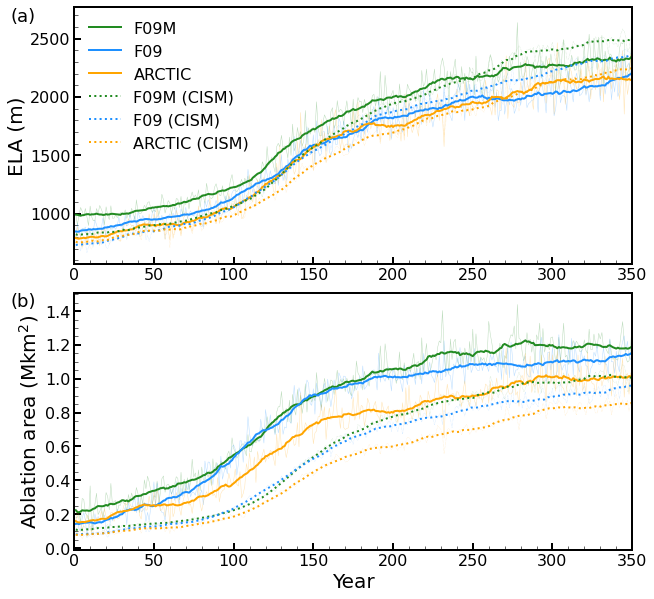

In [35]:
# length weighted algorithm
fig = plt.figure(figsize = (10,10))
gs=GridSpec(10,10)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 16
size_text = 18
#width_line = 2
size_marker = 27
alpha_marker = 0.3

year = np.arange(1,351)

#-------------------------------------------- ELA --------------------------------------------
ax1 = plt.subplot(gs[0:5,:])

ax1.plot(year, f09_ela_GrIS_ah_sqrt, color='forestgreen', linewidth=0.5, alpha=alpha_marker)
ax1.plot(year, f09_nohacks_ela_GrIS_ah_sqrt, color='dodgerblue', linewidth=0.5, alpha=alpha_marker)
ax1.plot(year, ARCTIC_ela_GrIS_ah_sqrt, color='orange', linewidth=0.5, alpha=alpha_marker)
#ax1.plot(year, ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3, color='mediumpurple', linewidth=0.5, alpha=alpha_marker)

ax1.plot(year, F09M_cism_ela_GrIS_ah_sqrt, color='forestgreen', linestyle=':', linewidth=0.5, alpha=alpha_marker)
ax1.plot(year, F09_cism_ela_GrIS_ah_sqrt, color='dodgerblue', linestyle=':', linewidth=0.5, alpha=alpha_marker)
ax1.plot(year, ARCTIC_cism_ela_GrIS_ah_sqrt, color='orange', linestyle=':', linewidth=0.5, alpha=alpha_marker)

ax1.plot(year, f09_ela_GrIS_ah_sqrt_rm, color='forestgreen', linewidth=2, label='F09M')
ax1.plot(year, f09_nohacks_ela_GrIS_ah_sqrt_rm, color='dodgerblue', linewidth=2, label='F09')
ax1.plot(year, ARCTIC_ela_GrIS_ah_sqrt_rm, color='orange', linewidth=2, label='ARCTIC')
#ax1.plot(year, ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3_rm, color='mediumpurple', linewidth = 2, label='ARCTIC2f09')

ax1.plot(year, F09M_cism_ela_GrIS_ah_sqrt_rm, color='forestgreen', linestyle=':', linewidth=2, label='F09M (CISM)')
ax1.plot(year, F09_cism_ela_GrIS_ah_sqrt_rm, color='dodgerblue', linestyle=':', linewidth=2, label='F09 (CISM)')
ax1.plot(year, ARCTIC_cism_ela_GrIS_ah_sqrt_rm, color='orange', linestyle=':', linewidth=2, label='ARCTIC (CISM)')

ax1.set_xlim([0, 350])
#ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('ELA (m)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
plt.text(-40, 2650, '(a)', fontsize=size_text)

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- Ablation area --------------------------------------------
ax2 = plt.subplot(gs[5:10,:])

ax2.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='forestgreen', linewidth=0.5, alpha=alpha_marker)
ax2.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='dodgerblue', linewidth=0.5, alpha=alpha_marker)
ax2.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='orange', linewidth=0.5, alpha=alpha_marker)
#ax2.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, color='mediumpurple', linewidth=0.5, alpha=alpha_marker)

ax2.plot(year, F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, color='forestgreen', linestyle=':', linewidth=0.5, alpha=alpha_marker)
ax2.plot(year, F09_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, color='dodgerblue', linestyle=':', linewidth=0.5, alpha=alpha_marker)
ax2.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, color='orange', linestyle=':', linewidth=0.5, alpha=alpha_marker)

ax2.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='forestgreen', linewidth=2, label='F09M')
ax2.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='dodgerblue', linewidth=2, label='F09')
ax2.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='orange', linewidth=2, label='ARCTIC')
#ax2.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3_rm/1e12, color='mediumpurple', linewidth = 2, label='ARCTIC2f09')

ax2.plot(year, F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm/1e12, color='forestgreen', linestyle=':', linewidth=2, label='F09M')
ax2.plot(year, F09_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm/1e12, color='dodgerblue', linestyle=':', linewidth=2, label='F09')
ax2.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm/1e12, color='orange', linestyle=':', linewidth=2, label='ARCTIC')

ax2.set_xlim([0, 350])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
plt.text(-40, 1.43, '(b)', fontsize=size_text)


plt.subplots_adjust(wspace=.5, hspace=1.)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_ELA_ablation_area_CISM_CAM.png', dpi=500, bbox_inches='tight', facecolor='w', transparent=False)

#### Ablation area evolution + ELA vs ablation area (CAM)

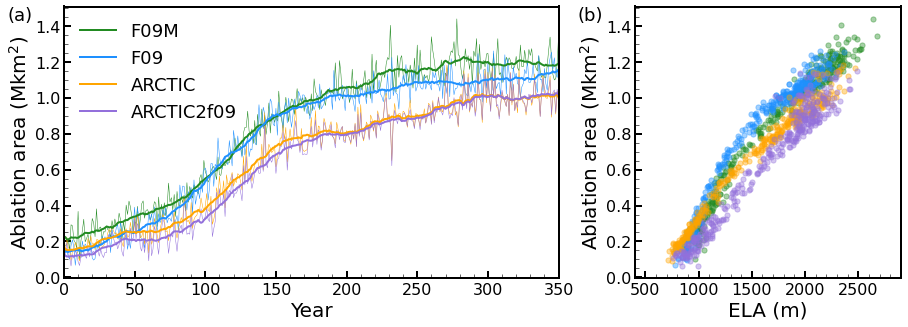

In [30]:
# length weighted algorithm
fig = plt.figure(figsize = (15,5))
gs=GridSpec(5,15)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
#width_line = 2
size_marker = 27

year = np.arange(1,351)

#-------------------------------------------- Ablation area --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:9])

ax1.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='forestgreen', linewidth = 0.5)
ax1.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='dodgerblue', linewidth = 0.5)
ax1.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='orange', linewidth = 0.5)
ax1.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, color='mediumpurple', linewidth = 0.5)

ax1.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='forestgreen', linewidth = 2, label='F09M')
ax1.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='dodgerblue', linewidth = 2, label='F09')
ax1.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='orange', linewidth = 2, label='ARCTIC')
ax1.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3_rm/1e12, color='mediumpurple', linewidth = 2, label='ARCTIC2f09')

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
plt.text(-40, 1.43, '(a)', fontsize=size_text)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- ELA-Ablation area --------------------------------------------
ax3 = plt.subplot(gs[0:5,10:15])

ax3.scatter(f09_ela_GrIS_ah_sqrt, f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='forestgreen', s=size_marker, alpha=0.4, label='F09M');
ax3.scatter(f09_nohacks_ela_GrIS_ah_sqrt, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='dodgerblue', s=size_marker, alpha=0.4, label='F09');
ax3.scatter(ARCTIC_ela_GrIS_ah_sqrt, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='orange', s=size_marker, alpha=0.4, label='ARCTIC');
ax3.scatter(ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, color='mediumpurple', s=size_marker, alpha=0.4, label='ARCTIC2f09');

ax3.set_xlim([400, 2900])
ax3.set_xlabel('ELA (m)', fontsize=size_label)
ax3.set_ylabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.text(-140, 1.43, '(b)', fontsize=size_text)


plt.subplots_adjust(wspace=.5, hspace=1.)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_ablation_area_scatter_ELA_ablation_area_ah_sqrt.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

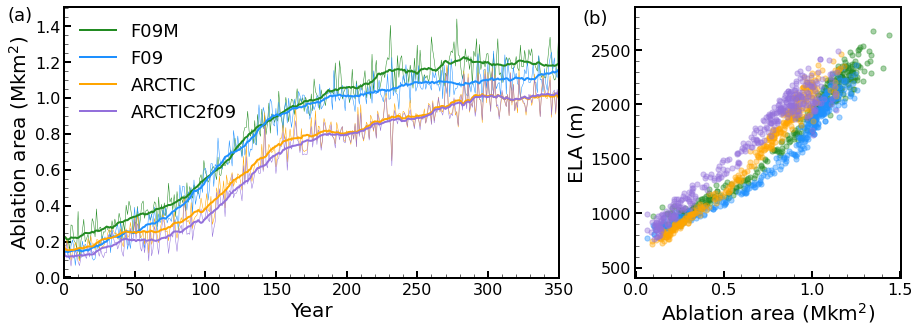

In [28]:
## Flip x and y axis for panel (b)
# length weighted algorithm
fig = plt.figure(figsize = (15,5))
gs=GridSpec(5,15)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 20
size_legend = 18
size_text = 18
#width_line = 2
size_marker = 27

year = np.arange(1,351)

#-------------------------------------------- Ablation area --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:9])

ax1.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='forestgreen', linewidth = 0.5)
ax1.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='dodgerblue', linewidth = 0.5)
ax1.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='orange', linewidth = 0.5)
ax1.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, color='mediumpurple', linewidth = 0.5)

ax1.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='forestgreen', linewidth = 2, label='F09M')
ax1.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='dodgerblue', linewidth = 2, label='F09')
ax1.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='orange', linewidth = 2, label='ARCTIC')
ax1.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3_rm/1e12, color='mediumpurple', linewidth = 2, label='ARCTIC2f09')

ax1.set_xlim([0, 350])
ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
plt.text(-40, 1.43, '(a)', fontsize=size_text)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- ELA-Ablation area --------------------------------------------
ax3 = plt.subplot(gs[0:5,10:15])

ax3.scatter(f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, f09_ela_GrIS_ah_sqrt, color='forestgreen', s=size_marker, alpha=0.4, label='F09M');
ax3.scatter(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, f09_nohacks_ela_GrIS_ah_sqrt, color='dodgerblue', s=size_marker, alpha=0.4, label='F09');
ax3.scatter(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, ARCTIC_ela_GrIS_ah_sqrt, color='orange', s=size_marker, alpha=0.4, label='ARCTIC');
ax3.scatter(ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3, color='mediumpurple', s=size_marker, alpha=0.4, label='ARCTIC2f09');

ax3.set_ylim([400, 2900])
ax3.set_xlabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax3.set_ylabel('ELA (m)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.text(-0.3, 2745, '(b)', fontsize=size_text)


plt.subplots_adjust(wspace=.5, hspace=1.)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_ablation_area_scatter_ELA_ablation_area_ah_sqrt_flipxy.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

#### ELA vs ablation area (CISM, CAM)

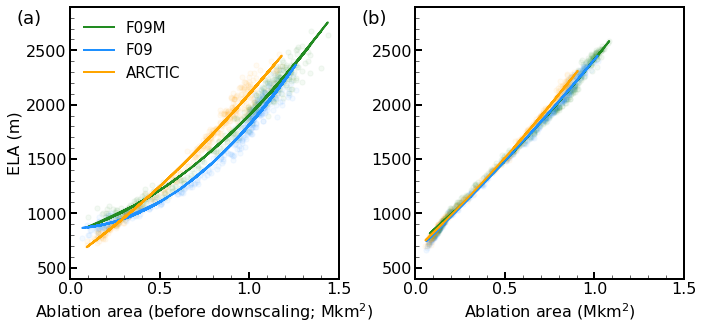

In [56]:
# Add regression
fig = plt.figure(figsize = (11,5))
gs=GridSpec(5,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 16
size_legend = 15
size_text = 18
width_line = 2
size_marker = 27
alpha_marker = 0.05

year = np.arange(1,351)

#-------------------------------------------- CAM --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:5])

ax1.scatter(f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, f09_ela_GrIS_ah_sqrt, color='forestgreen', s=size_marker, alpha=alpha_marker);
ax1.scatter(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, f09_nohacks_ela_GrIS_ah_sqrt, color='dodgerblue', s=size_marker, alpha=alpha_marker);
ax1.scatter(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, ARCTIC_ela_GrIS_ah_sqrt, color='orange', s=size_marker, alpha=alpha_marker);
#ax1.scatter(ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3, color='mediumpurple', s=size_marker, alpha=0.4, label='ARCTIC2f09');

plt.plot(f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, F09M_ela_pred, color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, F09_ela_pred, color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, ARCTIC_ela_pred, color='orange', linewidth=width_line, label='ARCTIC')

ax1.set_xlim([0, 1.5])
ax1.set_ylim([400, 2900])
ax1.set_xlabel('Ablation area (before downscaling; M$\mathregular{km^{2}}$)', fontsize=size_label)
ax1.set_ylabel('ELA (m)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
plt.text(-0.3, 2745, '(a)', fontsize=size_text)

ax1.legend(loc = 'best', frameon = False, prop={'size':size_legend}, ncol=1)

#-------------------------------------------- CISM --------------------------------------------
ax2 = plt.subplot(gs[0:5,6:11])

ax2.scatter(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, F09M_cism_ela_GrIS_ah_sqrt_read, color='forestgreen', s=size_marker, alpha=alpha_marker, label='F09M');
ax2.scatter(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, F09_cism_ela_GrIS_ah_sqrt_read, color='dodgerblue', s=size_marker, alpha=alpha_marker, label='F09');
ax2.scatter(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, ARCTIC_cism_ela_GrIS_ah_sqrt_read, color='orange', s=size_marker, alpha=alpha_marker, label='ARCTIC');

plt.plot(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, F09M_cism_ela_pred, color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, F09_cism_ela_pred, color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, ARCTIC_cism_ela_pred, color='orange', linewidth=width_line, label='ARCTIC')

ax2.set_xlim([0, 1.5])
ax2.set_ylim([400, 2900])
ax2.set_xlabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
#ax2.set_ylabel('ELA (m)', fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
plt.text(-0.3, 2745, '(b)', fontsize=size_text)


plt.subplots_adjust(wspace=.5, hspace=1.)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Scatter_ELA_ablation_area_ah_sqrt_CAM_CISM_2dregression.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

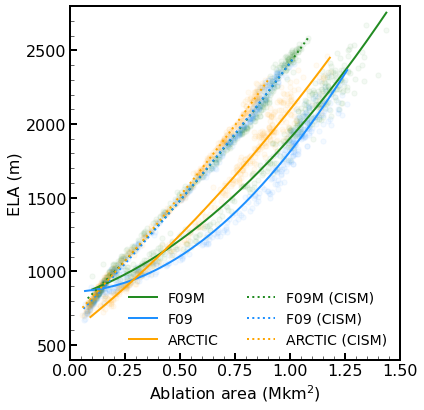

In [44]:
# Put together
fig = plt.figure(figsize = (13.5,6.5))
gs=GridSpec(5,11)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 16
size_label = 16
size_legend = 14
size_text = 18
width_line = 2
size_marker = 27
alpha_marker = 0.05

year = np.arange(1,351)

#-------------------------------------------- CAM --------------------------------------------
ax1 = plt.subplot(gs[0:5,0:5])

ax1.scatter(f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, f09_ela_GrIS_ah_sqrt, color='forestgreen', s=size_marker, alpha=alpha_marker);
ax1.scatter(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, f09_nohacks_ela_GrIS_ah_sqrt, color='dodgerblue', s=size_marker, alpha=alpha_marker);
ax1.scatter(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, ARCTIC_ela_GrIS_ah_sqrt, color='orange', s=size_marker, alpha=alpha_marker);
#ax1.scatter(ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3, color='mediumpurple', s=size_marker, alpha=0.4, label='ARCTIC2f09');

ax1.scatter(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, F09M_cism_ela_GrIS_ah_sqrt, color='forestgreen', s=size_marker, alpha=alpha_marker);
ax1.scatter(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, F09_cism_ela_GrIS_ah_sqrt, color='dodgerblue', s=size_marker, alpha=alpha_marker);
ax1.scatter(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, ARCTIC_cism_ela_GrIS_ah_sqrt, color='orange', s=size_marker, alpha=alpha_marker);

plt.plot((f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12).sortby(f09_int_1pctCO2_4xext_GrIS_ablation_area), xr.DataArray(F09M_ela_pred).sortby(f09_int_1pctCO2_4xext_GrIS_ablation_area), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot((f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12).sortby(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area), xr.DataArray(F09_ela_pred).sortby(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot((ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12).sortby(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area), xr.DataArray(ARCTIC_ela_pred).sortby(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area), color='orange', linewidth=width_line, label='ARCTIC')

plt.plot((F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12).sortby(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km), xr.DataArray(F09M_cism_ela_pred).rename({'dim_0': 'time'}).sortby(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M (CISM)')
plt.plot((F09_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12).sortby(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km), xr.DataArray(F09_cism_ela_pred).rename({'dim_0': 'time'}).sortby(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09 (CISM)')
plt.plot((ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12).sortby(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km), xr.DataArray(ARCTIC_cism_ela_pred).rename({'dim_0': 'time'}).sortby(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC (CISM)')

ax1.set_xlim([0, 1.5])
ax1.set_ylim([400, 2800])
ax1.set_xlabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax1.set_ylabel('ELA (m)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
#plt.text(-0.3, 2745, '(a)', fontsize=size_text)

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=2)

#-------------------------------------------- CISM --------------------------------------------
#ax2 = plt.subplot(gs[0:5,6:11])

#ax2.set_xlim([0, 1.5])
#ax2.set_ylim([400, 2900])
#ax2.set_xlabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
#ax2.set_ylabel('ELA (m)', fontsize=size_label)
#ax2.xaxis.set_minor_locator(AutoMinorLocator())
#ax2.yaxis.set_minor_locator(AutoMinorLocator())
#ax2.tick_params(which='major', length=7, width=2, direction='in')
#ax2.tick_params(which='minor', length=4, direction='in')
#ax2.tick_params(labelsize=size_tick)
#plt.text(-0.3, 2745, '(b)', fontsize=size_text)


plt.subplots_adjust(wspace=.5, hspace=1.)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/Scatter_ELA_ablation_area_ah_sqrt_CAM_CISM_2dregression_together.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

#### ELA and ablation area evolution + ELA vs ablation area (CISM, CAM)

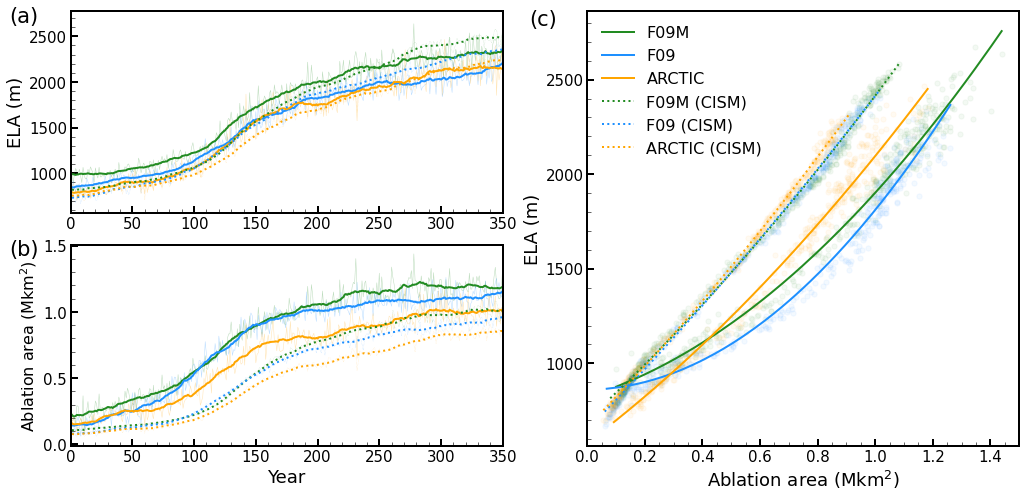

In [46]:
# length weighted algorithm
fig = plt.figure(figsize = (17,8))
gs=GridSpec(8,17)
plt.rcParams['axes.linewidth'] = 2 #set the value globally

size_tick = 15
size_label = 18
size_legend = 16
size_text = 21
width_line = 2
size_marker = 27
alpha_marker = 0.3

year = np.arange(1,351)

#-------------------------------------------- ELA --------------------------------------------
ax1 = plt.subplot(gs[0:4,0:8])

ax1.plot(year, f09_ela_GrIS_ah_sqrt, color='forestgreen', linewidth=0.5, alpha=alpha_marker)
ax1.plot(year, f09_nohacks_ela_GrIS_ah_sqrt, color='dodgerblue', linewidth=0.5, alpha=alpha_marker)
ax1.plot(year, ARCTIC_ela_GrIS_ah_sqrt, color='orange', linewidth=0.5, alpha=alpha_marker)
#ax1.plot(year, ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3, color='mediumpurple', linewidth=0.5, alpha=alpha_marker)

ax1.plot(year, F09M_cism_ela_GrIS_ah_sqrt, color='forestgreen', linestyle=':', linewidth=0.5, alpha=alpha_marker)
ax1.plot(year, F09_cism_ela_GrIS_ah_sqrt, color='dodgerblue', linestyle=':', linewidth=0.5, alpha=alpha_marker)
ax1.plot(year, ARCTIC_cism_ela_GrIS_ah_sqrt, color='orange', linestyle=':', linewidth=0.5, alpha=alpha_marker)

ax1.plot(year, f09_ela_GrIS_ah_sqrt_rm, color='forestgreen', linewidth=width_line, label='F09M')
ax1.plot(year, f09_nohacks_ela_GrIS_ah_sqrt_rm, color='dodgerblue', linewidth=width_line, label='F09')
ax1.plot(year, ARCTIC_ela_GrIS_ah_sqrt_rm, color='orange', linewidth=width_line, label='ARCTIC')
#ax1.plot(year, ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3_rm, color='mediumpurple', linewidth=width_line, label='ARCTIC2f09')

ax1.plot(year, F09M_cism_ela_GrIS_ah_sqrt_rm, color='forestgreen', linestyle=':', linewidth=width_line, label='F09M (CISM)')
ax1.plot(year, F09_cism_ela_GrIS_ah_sqrt_rm, color='dodgerblue', linestyle=':', linewidth=width_line, label='F09 (CISM)')
ax1.plot(year, ARCTIC_cism_ela_GrIS_ah_sqrt_rm, color='orange', linestyle=':', linewidth=width_line, label='ARCTIC (CISM)')

ax1.set_xlim([0, 350])
#ax1.set_xlabel('Year', fontsize=size_label)
ax1.set_ylabel('ELA (m)', fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which='major', length=7, width=2, direction='in')
ax1.tick_params(which='minor', length=4, direction='in')
ax1.tick_params(labelsize=size_tick)
plt.text(-50, 2650, '(a)', fontsize=size_text)

#-------------------------------------------- Ablation area --------------------------------------------
ax2 = plt.subplot(gs[4:8,0:8])

ax2.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='forestgreen', linewidth=0.5, alpha=alpha_marker)
ax2.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='dodgerblue', linewidth=0.5, alpha=alpha_marker)
ax2.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, color='orange', linewidth=0.5, alpha=alpha_marker)
#ax2.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3/1e12, color='mediumpurple', linewidth=0.5, alpha=alpha_marker)

ax2.plot(year, F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, color='forestgreen', linestyle=':', linewidth=0.5, alpha=alpha_marker)
ax2.plot(year, F09_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, color='dodgerblue', linestyle=':', linewidth=0.5, alpha=alpha_marker)
ax2.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, color='orange', linestyle=':', linewidth=0.5, alpha=alpha_marker)

ax2.plot(year, f09_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='forestgreen', linewidth=width_line, label='F09M')
ax2.plot(year, f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='dodgerblue', linewidth=width_line, label='F09')
ax2.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_rm/1e12, color='orange', linewidth=width_line, label='ARCTIC')
#ax2.plot(year, ARCTIC2f09_int_1pctCO2_4xext_GrIS_ablation_area_maskv3_rm/1e12, color='mediumpurple', linewidth=width_line, label='ARCTIC2f09')

ax2.plot(year, F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm/1e12, color='forestgreen', linestyle=':', linewidth=width_line, label='F09M')
ax2.plot(year, F09_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm/1e12, color='dodgerblue', linestyle=':', linewidth=width_line, label='F09')
ax2.plot(year, ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km_rm/1e12, color='orange', linestyle=':', linewidth=width_line, label='ARCTIC')

ax2.set_xlim([0, 350])
#ax2.set_ylim([0, 1.5])
ax2.set_xlabel('Year', fontsize=size_label)
ax2.set_ylabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label-2)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which='major', length=7, width=2, direction='in')
ax2.tick_params(which='minor', length=4, direction='in')
ax2.tick_params(labelsize=size_tick)
plt.text(-50, 1.43, '(b)', fontsize=size_text)

#-------------------------------------------- ELA vs ablation area --------------------------------------------
ax3 = plt.subplot(gs[0:8,9:17])

alpha_marker = 0.05

ax3.scatter(f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12, f09_ela_GrIS_ah_sqrt, color='forestgreen', s=size_marker, alpha=alpha_marker);
ax3.scatter(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12, f09_nohacks_ela_GrIS_ah_sqrt, color='dodgerblue', s=size_marker, alpha=alpha_marker);
ax3.scatter(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12, ARCTIC_ela_GrIS_ah_sqrt, color='orange', s=size_marker, alpha=alpha_marker);

ax3.scatter(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, F09M_cism_ela_GrIS_ah_sqrt, color='forestgreen', s=size_marker, alpha=alpha_marker);
ax3.scatter(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, F09_cism_ela_GrIS_ah_sqrt, color='dodgerblue', s=size_marker, alpha=alpha_marker);
ax3.scatter(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12, ARCTIC_cism_ela_GrIS_ah_sqrt, color='orange', s=size_marker, alpha=alpha_marker);

plt.plot((f09_int_1pctCO2_4xext_GrIS_ablation_area/1e12).sortby(f09_int_1pctCO2_4xext_GrIS_ablation_area), xr.DataArray(F09M_ela_pred).sortby(f09_int_1pctCO2_4xext_GrIS_ablation_area), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot((f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area/1e12).sortby(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area), xr.DataArray(F09_ela_pred).sortby(f09_nohacks_int_1pctCO2_4xext_GrIS_ablation_area), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot((ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area/1e12).sortby(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area), xr.DataArray(ARCTIC_ela_pred).sortby(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area), color='orange', linewidth=width_line, label='ARCTIC')

plt.plot((F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12).sortby(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km), xr.DataArray(F09M_cism_ela_pred).rename({'dim_0': 'time'}).sortby(F09M_int_1pctCO2_4xext_GrIS_ablation_area_4km), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M (CISM)')
plt.plot((F09_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12).sortby(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km), xr.DataArray(F09_cism_ela_pred).rename({'dim_0': 'time'}).sortby(F09_int_1pctCO2_4xext_GrIS_ablation_area_4km), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09 (CISM)')
plt.plot((ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km/1e12).sortby(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km), xr.DataArray(ARCTIC_cism_ela_pred).rename({'dim_0': 'time'}).sortby(ARCTIC_int_1pctCO2_4xext_GrIS_ablation_area_4km), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC (CISM)')

ax3.set_xlim([0, 1.5])
#ax3.set_ylim([550, 2800])
ax3.set_xlabel('Ablation area (M$\mathregular{km^{2}}$)', fontsize=size_label)
ax3.set_ylabel('ELA (m)', fontsize=size_label)
ax3.xaxis.set_minor_locator(AutoMinorLocator())
ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.tick_params(which='major', length=7, width=2, direction='in')
ax3.tick_params(which='minor', length=4, direction='in')
ax3.tick_params(labelsize=size_tick)
plt.text(-0.2, 2785, '(c)', fontsize=size_text)

ax3.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)


plt.subplots_adjust(wspace=.9, hspace=1.2)
plt.savefig(home_dir+'2022-VR-dynamic-GrIS/github/plot/tseries_scatter_ELA_ablation_area_CISM_CAM.png', dpi=500, bbox_inches='tight', facecolor='w', transparent=False)

### Calculate initial ice sheet area

In [16]:
BG7_GrIS_area = xr.DataArray(BG7_GrIS_mask * f09_area).sum(axis=(1,2))

f09_nohacks_piControl_GrIS_area = xr.DataArray(f09_nohacks_GrIS_mask_piControl * f09_area).sum(axis=(1,2))

ARCTIC_piControl_GrIS_area = xr.DataArray(ARCTIC_GrIS_mask_piControl * ARCTIC_area).sum(axis=1)

In [18]:
print('Initial GrIS area at year 0 (10^6 km^2):')
print('F09M', BG7_GrIS_area[148].values/1e12)
print('F09', f09_nohacks_piControl_GrIS_area[-1].values/1e12)
print('ARCTIC', ARCTIC_piControl_GrIS_area[-1].values/1e12)

Initial GrIS area at year 0 (10^6 km^2):
F09M 2.0404720612603997
F09 2.1067508620722086
ARCTIC 2.1171280342580885


## 2. Relationships between albedo/ELA/ablation area and JJA mean temperature <a class="anchor" id="second-bullet"></a>

### Read data

#### Albedo

In [58]:
dataset = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/github/data/processed/avg_albedo_JJA.nc')

f09_albedo_JJA = dataset['albedo_JJA_F09M']
f09_nohacks_albedo_JJA = dataset['albedo_JJA_F09']
ARCTIC_albedo_JJA = dataset['albedo_JJA_ARCTIC']

#### ELA

In [44]:
## Read ELA time series (CAM)
f09_ela = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_ela_GrIS_yearly_ah_sqrt.nc')['ELA']
f09_nohacks_ela = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ela_GrIS_yearly_ah_sqrt.nc')['ELA']

ARCTIC_ela_GrIS_P1 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p1_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_P2 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p2_ah_sqrt.nc')['ELA']
ARCTIC_ela_GrIS_P3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_GrIS_yearly_p3_ah_sqrt.nc')['ELA']
ARCTIC_ela = xr.concat([ARCTIC_ela_GrIS_P1, ARCTIC_ela_GrIS_P2, ARCTIC_ela_GrIS_P3], dim='year')

#ARCTIC2f09_ela_GrIS_ah_sqrt_maskv3 = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC2f09_ela_GrIS_yearly_ah_sqrt_maskv3.nc')['ELA']

In [45]:
## Read ELA time series (CISM)
f09_cism_ela = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09muntjewerf/f09_ela_CISM_GrIS_yearly_ah_sqrt.nc')['ELA']
f09_nohacks_cism_ela = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/f09nohacks/f09_nohacks_ela_CISM_GrIS_yearly_ah_sqrt.nc')['ELA']
ARCTIC_cism_ela = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/arctic/ARCTIC_ela_CISM_GrIS_yearly_ah_sqrt.nc')['ELA']

#### Ablation area

In [5]:
dataset = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/github/data/processed/ablation_area.nc')

f09_ablation_area = dataset['ablation_area_F09M']
f09_nohacks_ablation_area = dataset['ablation_area_F09']
ARCTIC_ablation_area = dataset['ablation_area_ARCTIC']
f09_ablation_area_4km = dataset['ablation_area_4km_F09M']
f09_nohacks_ablation_area_4km = dataset['ablation_area_4km_F09']
ARCTIC_ablation_area_4km = dataset['ablation_area_4km_ARCTIC']

#### Temperature

In [6]:
dataset = xr.open_dataset(home_dir+'2022-VR-dynamic-GrIS/github/data/processed/avg_TREFHT_Tv_JJA.nc')

f09_avg_TREFHT_JJA = dataset['TREFHT_JJA_F09M']
f09_nohacks_avg_TREFHT_JJA = dataset['TREFHT_JJA_F09']
ARCTIC_avg_TREFHT_JJA = dataset['TREFHT_JJA_ARCTIC']
f09_avg_Tv_JJA = dataset['Tv_JJA_F09M']
f09_nohacks_avg_Tv_JJA = dataset['Tv_JJA_F09']
ARCTIC_avg_Tv_JJA = dataset['Tv_JJA_ARCTIC']

### Polynomial regression

#### Albedo

In [67]:
degree = 3  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree)

# T2m
f09_TREFHT_JJA_poly = poly.fit_transform(f09_avg_TREFHT_JJA.values.reshape(-1, 1))
f09_nohacks_TREFHT_JJA_poly = poly.fit_transform(f09_nohacks_avg_TREFHT_JJA.values.reshape(-1, 1))
ARCTIC_TREFHT_JJA_poly = poly.fit_transform(ARCTIC_avg_TREFHT_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_TREFHT_JJA_poly, f09_albedo_JJA)
f09_albedo_JJA_pred = model1.predict(f09_TREFHT_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_TREFHT_JJA_poly, f09_nohacks_albedo_JJA)
f09_nohacks_albedo_JJA_pred = model2.predict(f09_nohacks_TREFHT_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_TREFHT_JJA_poly, ARCTIC_albedo_JJA)
ARCTIC_albedo_JJA_pred = model3.predict(ARCTIC_TREFHT_JJA_poly)

In [68]:
# Tv (500-1000hPa)
f09_Tv_JJA_poly = poly.fit_transform(f09_avg_Tv_JJA.values.reshape(-1, 1))
f09_nohacks_Tv_JJA_poly = poly.fit_transform(f09_nohacks_avg_Tv_JJA.values.reshape(-1, 1))
ARCTIC_Tv_JJA_poly = poly.fit_transform(ARCTIC_avg_Tv_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_Tv_JJA_poly, f09_albedo_JJA)
f09_albedo_JJA_pred2 = model1.predict(f09_Tv_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_Tv_JJA_poly, f09_nohacks_albedo_JJA)
f09_nohacks_albedo_JJA_pred2 = model2.predict(f09_nohacks_Tv_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_Tv_JJA_poly, ARCTIC_albedo_JJA)
ARCTIC_albedo_JJA_pred2 = model3.predict(ARCTIC_Tv_JJA_poly)

#### ELA

In [48]:
degree = 3  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree)

# T2m
f09_TREFHT_JJA_poly = poly.fit_transform(f09_avg_TREFHT_JJA.values.reshape(-1, 1))
f09_nohacks_TREFHT_JJA_poly = poly.fit_transform(f09_nohacks_avg_TREFHT_JJA.values.reshape(-1, 1))
ARCTIC_TREFHT_JJA_poly = poly.fit_transform(ARCTIC_avg_TREFHT_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_TREFHT_JJA_poly, f09_ela)
f09_ela_pred = model1.predict(f09_TREFHT_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_TREFHT_JJA_poly, f09_nohacks_ela)
f09_nohacks_ela_pred = model2.predict(f09_nohacks_TREFHT_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_TREFHT_JJA_poly, ARCTIC_ela)
ARCTIC_ela_pred = model3.predict(ARCTIC_TREFHT_JJA_poly)

In [49]:
# T2m
f09_TREFHT_JJA_poly = poly.fit_transform(f09_avg_TREFHT_JJA.values.reshape(-1, 1))
f09_nohacks_TREFHT_JJA_poly = poly.fit_transform(f09_nohacks_avg_TREFHT_JJA.values.reshape(-1, 1))
ARCTIC_TREFHT_JJA_poly = poly.fit_transform(ARCTIC_avg_TREFHT_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_TREFHT_JJA_poly, f09_cism_ela)
f09_cism_ela_pred = model1.predict(f09_TREFHT_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_TREFHT_JJA_poly, f09_nohacks_cism_ela)
f09_nohacks_cism_ela_pred = model2.predict(f09_nohacks_TREFHT_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_TREFHT_JJA_poly, ARCTIC_cism_ela)
ARCTIC_cism_ela_pred = model3.predict(ARCTIC_TREFHT_JJA_poly)

In [50]:
# Tv (500-1000hPa)
f09_Tv_JJA_poly = poly.fit_transform(f09_avg_Tv_JJA.values.reshape(-1, 1))
f09_nohacks_Tv_JJA_poly = poly.fit_transform(f09_nohacks_avg_Tv_JJA.values.reshape(-1, 1))
ARCTIC_Tv_JJA_poly = poly.fit_transform(ARCTIC_avg_Tv_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_Tv_JJA_poly, f09_ela)
f09_ela_pred2 = model1.predict(f09_Tv_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_Tv_JJA_poly, f09_nohacks_ela)
f09_nohacks_ela_pred2 = model2.predict(f09_nohacks_Tv_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_Tv_JJA_poly, ARCTIC_ela)
ARCTIC_ela_pred2 = model3.predict(ARCTIC_Tv_JJA_poly)

In [51]:
# Tv (500-1000hPa)
f09_Tv_JJA_poly = poly.fit_transform(f09_avg_Tv_JJA.values.reshape(-1, 1))
f09_nohacks_Tv_JJA_poly = poly.fit_transform(f09_nohacks_avg_Tv_JJA.values.reshape(-1, 1))
ARCTIC_Tv_JJA_poly = poly.fit_transform(ARCTIC_avg_Tv_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_Tv_JJA_poly, f09_cism_ela)
f09_cism_ela_pred2 = model1.predict(f09_Tv_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_Tv_JJA_poly, f09_nohacks_cism_ela)
f09_nohacks_cism_ela_pred2 = model2.predict(f09_nohacks_Tv_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_Tv_JJA_poly, ARCTIC_cism_ela)
ARCTIC_cism_ela_pred2 = model3.predict(ARCTIC_Tv_JJA_poly)

#### Ablation area

In [28]:
degree = 3  # Degree of the polynomial
poly = PolynomialFeatures(degree=degree)

# T2m
f09_TREFHT_JJA_poly = poly.fit_transform(f09_avg_TREFHT_JJA.values.reshape(-1, 1))
f09_nohacks_TREFHT_JJA_poly = poly.fit_transform(f09_nohacks_avg_TREFHT_JJA.values.reshape(-1, 1))
ARCTIC_TREFHT_JJA_poly = poly.fit_transform(ARCTIC_avg_TREFHT_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_TREFHT_JJA_poly, f09_ablation_area)
f09_ablation_area_pred = model1.predict(f09_TREFHT_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_TREFHT_JJA_poly, f09_nohacks_ablation_area)
f09_nohacks_ablation_area_pred = model2.predict(f09_nohacks_TREFHT_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_TREFHT_JJA_poly, ARCTIC_ablation_area)
ARCTIC_ablation_area_pred = model3.predict(ARCTIC_TREFHT_JJA_poly)

In [29]:
# T2m
f09_TREFHT_JJA_poly = poly.fit_transform(f09_avg_TREFHT_JJA.values.reshape(-1, 1))
f09_nohacks_TREFHT_JJA_poly = poly.fit_transform(f09_nohacks_avg_TREFHT_JJA.values.reshape(-1, 1))
ARCTIC_TREFHT_JJA_poly = poly.fit_transform(ARCTIC_avg_TREFHT_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_TREFHT_JJA_poly, f09_ablation_area_4km)
f09_ablation_area_4km_pred = model1.predict(f09_TREFHT_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_TREFHT_JJA_poly, f09_nohacks_ablation_area_4km)
f09_nohacks_ablation_area_4km_pred = model2.predict(f09_nohacks_TREFHT_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_TREFHT_JJA_poly, ARCTIC_ablation_area_4km)
ARCTIC_ablation_area_4km_pred = model3.predict(ARCTIC_TREFHT_JJA_poly)

In [30]:
# Tv (500-1000hPa)
f09_Tv_JJA_poly = poly.fit_transform(f09_avg_Tv_JJA.values.reshape(-1, 1))
f09_nohacks_Tv_JJA_poly = poly.fit_transform(f09_nohacks_avg_Tv_JJA.values.reshape(-1, 1))
ARCTIC_Tv_JJA_poly = poly.fit_transform(ARCTIC_avg_Tv_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_Tv_JJA_poly, f09_ablation_area)
f09_ablation_area_pred2 = model1.predict(f09_Tv_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_Tv_JJA_poly, f09_nohacks_ablation_area)
f09_nohacks_ablation_area_pred2 = model2.predict(f09_nohacks_Tv_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_Tv_JJA_poly, ARCTIC_ablation_area)
ARCTIC_ablation_area_pred2 = model3.predict(ARCTIC_Tv_JJA_poly)

In [31]:
# Tv (500-1000hPa)
f09_Tv_JJA_poly = poly.fit_transform(f09_avg_Tv_JJA.values.reshape(-1, 1))
f09_nohacks_Tv_JJA_poly = poly.fit_transform(f09_nohacks_avg_Tv_JJA.values.reshape(-1, 1))
ARCTIC_Tv_JJA_poly = poly.fit_transform(ARCTIC_avg_Tv_JJA.values.reshape(-1, 1))

model1 = LinearRegression()
model1.fit(f09_Tv_JJA_poly, f09_ablation_area_4km)
f09_ablation_area_4km_pred2 = model1.predict(f09_Tv_JJA_poly)

model2 = LinearRegression()
model2.fit(f09_nohacks_Tv_JJA_poly, f09_nohacks_ablation_area_4km)
f09_nohacks_ablation_area_4km_pred2 = model2.predict(f09_nohacks_Tv_JJA_poly)

model3 = LinearRegression()
model3.fit(ARCTIC_Tv_JJA_poly, ARCTIC_ablation_area_4km)
ARCTIC_ablation_area_4km_pred2 = model3.predict(ARCTIC_Tv_JJA_poly)

### Plot

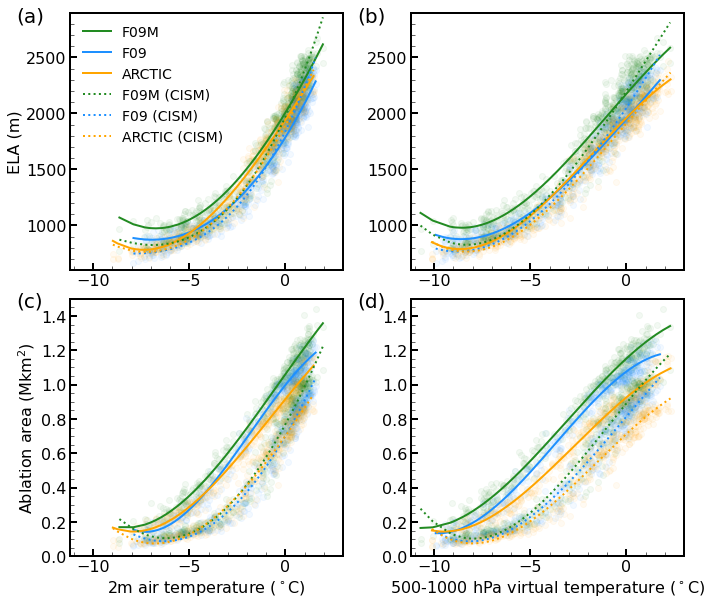

In [81]:
## ELA and ablation area
fig = plt.figure(figsize = (11,10))
gs=GridSpec(10,11)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 20
size_legend = 14
alpha_marker = 0.05
width_line = 2

#------------------------------------------T2m vs ELA------------------------------------------
ax1 = plt.subplot(gs[0:5,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_ela, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_ela, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_ela, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_cism_ela, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_cism_ela, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_cism_ela, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_ela_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_ela_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_ela_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')
plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_cism_ela_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M (CISM)')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_cism_ela_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09 (CISM)')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_cism_ela_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC (CISM)')

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([600, 2900])
#ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("ELA (m)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
plt.text(-14, 2820, '(a)', fontsize=size_text)

#------------------------------------------Lower troposphere virtual temp vs ELA------------------------------------------
ax2 = plt.subplot(gs[0:5,6:11])

plt.scatter(f09_avg_Tv_JJA-273.15, f09_ela, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_ela, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_ela, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.scatter(f09_avg_Tv_JJA-273.15, f09_cism_ela, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_cism_ela, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_cism_ela, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_ela_pred2).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_ela_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_ela_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')
plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_cism_ela_pred2).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_cism_ela_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_cism_ela_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([600, 2900])
#ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
plt.text(-14, 2820, '(b)', fontsize=size_text)

#------------------------------------------T2m vs ablation area------------------------------------------
ax1 = plt.subplot(gs[5:10,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_ablation_area/1e12, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_ablation_area/1e12, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_ablation_area/1e12, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_ablation_area_4km/1e12, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_ablation_area_4km/1e12, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_ablation_area_4km/1e12, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_ablation_area_pred/1e12).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_ablation_area_pred/1e12).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_ablation_area_pred/1e12).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')
plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_ablation_area_4km_pred/1e12).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M (CISM)')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_ablation_area_4km_pred/1e12).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09 (CISM)')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_ablation_area_4km_pred/1e12).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC (CISM)')

#ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([0, 1.5])
ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("Ablation area (M$\mathregular{km^{2}}$)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
plt.text(-14, 1.45, '(c)', fontsize=size_text)

#------------------------------------------Lower troposphere virtual temp vs ablation area------------------------------------------
ax2 = plt.subplot(gs[5:10,6:11])

plt.scatter(f09_avg_Tv_JJA-273.15, f09_ablation_area/1e12, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_ablation_area/1e12, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_ablation_area/1e12, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.scatter(f09_avg_Tv_JJA-273.15, f09_ablation_area_4km/1e12, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_ablation_area_4km/1e12, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_ablation_area_4km/1e12, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_ablation_area_pred2/1e12).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_ablation_area_pred2/1e12).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_ablation_area_pred2/1e12).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')
plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_ablation_area_4km_pred2/1e12).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_ablation_area_4km_pred2/1e12).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_ablation_area_4km_pred2/1e12).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([0, 1.5])
ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
plt.text(-14, 1.45, '(d)', fontsize=size_text)


plt.subplots_adjust(wspace=0.25, hspace=1.)
plt.savefig(
    home_dir+"2022-VR-dynamic-GrIS/github/plot/Scatter_T2m_Tv_lowertropo_vs_ELA_ablation_area.png",
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #

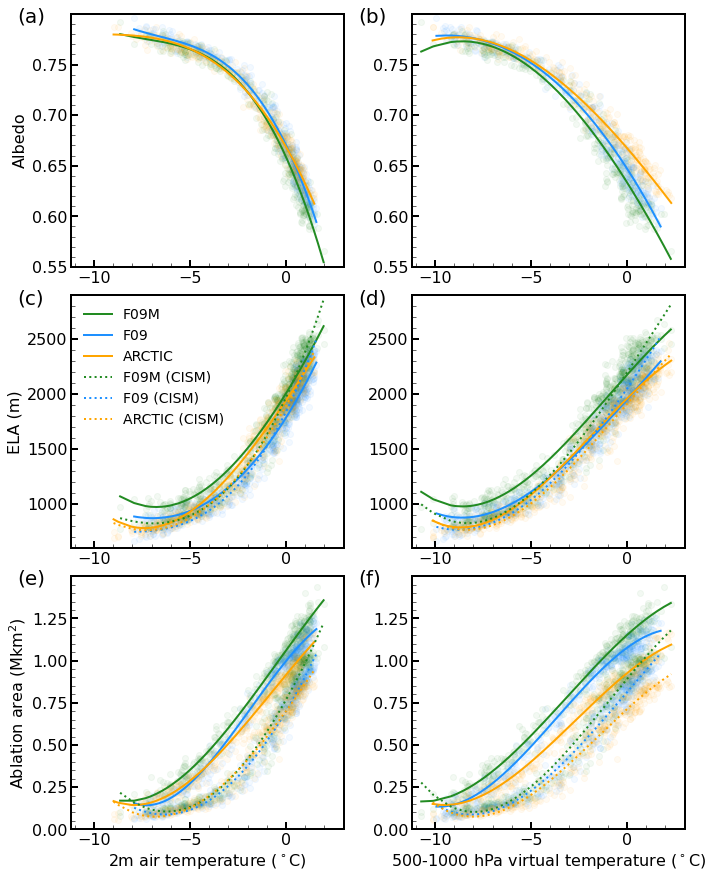

In [80]:
## albedo, ELA, and ablation area
fig = plt.figure(figsize = (11,15))
gs=GridSpec(15,11)
plt.rcParams['axes.titlepad'] =14
plt.rcParams["axes.linewidth"] = 2  # set the value globally

size_tick = 16
size_label = 16
size_text = 20
size_legend = 14
alpha_marker = 0.05
width_line = 2

#------------------------------------------T2m vs albedo------------------------------------------
ax1 = plt.subplot(gs[0:5,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')

#ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([0.55, 0.8])
#ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("Albedo", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
plt.text(-14, 0.792, '(a)', fontsize=size_text)

#------------------------------------------Lower troposphere virtual temp vs albedo------------------------------------------
ax2 = plt.subplot(gs[0:5,6:11])

plt.scatter(f09_avg_Tv_JJA-273.15, f09_albedo_JJA, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_albedo_JJA, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_albedo_JJA, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_albedo_JJA_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([0.55, 0.8])
#ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0.55,0.76,0.05))
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
plt.text(-14, 0.792, '(b)', fontsize=size_text)

#------------------------------------------T2m vs ELA------------------------------------------
ax1 = plt.subplot(gs[5:10,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_ela, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_ela, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_ela, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_cism_ela, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_cism_ela, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_cism_ela, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_ela_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_ela_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_ela_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')
plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_cism_ela_pred).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M (CISM)')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_cism_ela_pred).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09 (CISM)')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_cism_ela_pred).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC (CISM)')

ax1.legend(loc='best', frameon=False, prop={'size':size_legend}, ncol=1)

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([600, 2900])
#ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("ELA (m)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
plt.text(-14, 2820, '(c)', fontsize=size_text)

#------------------------------------------Lower troposphere virtual temp vs ELA------------------------------------------
ax2 = plt.subplot(gs[5:10,6:11])

plt.scatter(f09_avg_Tv_JJA-273.15, f09_ela, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_ela, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_ela, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.scatter(f09_avg_Tv_JJA-273.15, f09_cism_ela, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_cism_ela, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_cism_ela, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_ela_pred2).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_ela_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_ela_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')
plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_cism_ela_pred2).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_cism_ela_pred2).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_cism_ela_pred2).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([600, 2900])
#ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
plt.text(-14, 2820, '(d)', fontsize=size_text)

#------------------------------------------T2m vs ablation area------------------------------------------
ax1 = plt.subplot(gs[10:15,0:5])

plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_ablation_area/1e12, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_ablation_area/1e12, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_ablation_area/1e12, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.scatter(f09_avg_TREFHT_JJA-273.15, f09_ablation_area_4km/1e12, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_TREFHT_JJA-273.15, f09_nohacks_ablation_area_4km/1e12, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_TREFHT_JJA-273.15, ARCTIC_ablation_area_4km/1e12, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_ablation_area_pred/1e12).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_ablation_area_pred/1e12).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_ablation_area_pred/1e12).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, label='ARCTIC')
plt.plot(f09_avg_TREFHT_JJA.sortby(f09_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_ablation_area_4km_pred/1e12).rename({'dim_0': 'year'}).sortby(f09_avg_TREFHT_JJA), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M (CISM)')
plt.plot(f09_nohacks_avg_TREFHT_JJA.sortby(f09_nohacks_avg_TREFHT_JJA)-273.15, xr.DataArray(f09_nohacks_ablation_area_4km_pred/1e12).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_TREFHT_JJA), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09 (CISM)')
plt.plot(ARCTIC_avg_TREFHT_JJA.sortby(ARCTIC_avg_TREFHT_JJA)-273.15, xr.DataArray(ARCTIC_ablation_area_4km_pred/1e12).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_TREFHT_JJA), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC (CISM)')

ax1.set_xlim([-11.2, 3])
ax1.set_ylim([0, 1.5])
ax1.set_xlabel("2m air temperature ($^\circ$C)", fontsize=size_label)
ax1.set_ylabel("Ablation area (M$\mathregular{km^{2}}$)", fontsize=size_label)
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0,1.26,0.25))
ax1.tick_params(which="major", length=7, width=2, direction="in")
ax1.tick_params(which="minor", length=4, direction="in")
ax1.tick_params(labelsize=size_tick)
plt.text(-14, 1.45, '(e)', fontsize=size_text)

#------------------------------------------Lower troposphere virtual temp vs ablation area------------------------------------------
ax2 = plt.subplot(gs[10:15,6:11])

plt.scatter(f09_avg_Tv_JJA-273.15, f09_ablation_area/1e12, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_ablation_area/1e12, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_ablation_area/1e12, color='orange', alpha=alpha_marker)#, label='ARCTIC')
plt.scatter(f09_avg_Tv_JJA-273.15, f09_ablation_area_4km/1e12, color='forestgreen', alpha=alpha_marker)#, label='F09M')
plt.scatter(f09_nohacks_avg_Tv_JJA-273.15, f09_nohacks_ablation_area_4km/1e12, color='dodgerblue', alpha=alpha_marker)#, label='F09')
plt.scatter(ARCTIC_avg_Tv_JJA-273.15, ARCTIC_ablation_area_4km/1e12, color='orange', alpha=alpha_marker)#, label='ARCTIC')

plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_ablation_area_pred2/1e12).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_ablation_area_pred2/1e12).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_ablation_area_pred2/1e12).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, label='ARCTIC')
plt.plot(f09_avg_Tv_JJA.sortby(f09_avg_Tv_JJA)-273.15, xr.DataArray(f09_ablation_area_4km_pred2/1e12).rename({'dim_0': 'year'}).sortby(f09_avg_Tv_JJA), color='forestgreen', linewidth=width_line, linestyle=':', label='F09M')
plt.plot(f09_nohacks_avg_Tv_JJA.sortby(f09_nohacks_avg_Tv_JJA)-273.15, xr.DataArray(f09_nohacks_ablation_area_4km_pred2/1e12).rename({'dim_0': 'year'}).sortby(f09_nohacks_avg_Tv_JJA), color='dodgerblue', linewidth=width_line, linestyle=':', label='F09')
plt.plot(ARCTIC_avg_Tv_JJA.sortby(ARCTIC_avg_Tv_JJA)-273.15, xr.DataArray(ARCTIC_ablation_area_4km_pred2/1e12).rename({'dim_0': 'year'}).sortby(ARCTIC_avg_Tv_JJA), color='orange', linewidth=width_line, linestyle=':', label='ARCTIC')

ax2.set_xlim([-11.2, 3])
ax2.set_ylim([0, 1.5])
ax2.set_xlabel("500-1000 hPa virtual temperature ($^\circ$C)", fontsize=size_label)
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
plt.yticks(np.arange(0,1.26,0.25))
ax2.tick_params(which="major", length=7, width=2, direction="in")
ax2.tick_params(which="minor", length=4, direction="in")
ax2.tick_params(labelsize=size_tick)
plt.text(-14, 1.45, '(f)', fontsize=size_text)


plt.subplots_adjust(wspace=0.25, hspace=1.)
plt.savefig(
    home_dir+"2022-VR-dynamic-GrIS/github/plot/Scatter_T2m_Tv_lowertropo_vs_albedo_ELA_ablation_area.png",
    dpi=500,
    bbox_inches="tight",
    facecolor="w",
    transparent=False,
)  #